# Image analysis with $\texttt{LieDetect}$

Henrique Hennes https://github.com/HLovisiEnnes \
Raphaël Tinarrage https://raphaeltinarrage.github.io/

See the repo at https://github.com/HLovisiEnnes/LieDetect and the article at https://arxiv.org/abs/2309.03086

- **I. Pixel permutations**
    - I.1. $\mathrm{SO}(2)$-action on translated gorillas
    - I.2. $T^2$-action on translated gorillas
    - I.3. $\mathrm{SO}(2)$-action on rotated gorillas
- **II. Rotation of 3D objects**
    - II.1. $\mathrm{SU}(2)$-action on armadillo in $\mathbb{R}^8$
        - II.1.1. Illustrate the different rotation methods
        - II.1.2. Orbit detection with 'mesh' method
        - II.1.3. Orbit detection with 'voxels' method
        - II.1.4. Orbit detection with 'kde' method
    - II.2. Detection of eigengaps
    - II.3. $\mathrm{SU}(2)$-action on armadillo in $\mathbb{R}^{15}$
- **III. Harmonic analysis**
    - III.1. Translated gorillas with gaussian filter
    - III.2. Learning rotation matrices from armadillo, voxels embedding
    - III.3. Learning rotation matrices from armadillo, KDE embedding

In [1]:
# Standard imports.
import IPython

# Third-party imports.
import numpy as np
import sklearn, scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec
import open3d as o3d
import open3d.data
import tensorflow as tf
import miniball
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Local imports.
from orbits import sample_orbit_from_algebra, get_periods
from liepca import get_lie_pca_operator, print_covariance_eigenvalues, orthonormalize, print_norms
from optimization import find_closest_algebra

/home/rtinarra/.cache/pypoetry/virtualenvs/liedetect-8nEXKn2J-py3.12/lib/python3.12/site-packages/dash/dash.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, parse_version


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2025-06-24 09:49:42.817652: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-24 09:49:42.831877: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750751382.845473  407409 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750751382.849548  407409 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750751382.860473  407409 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# I. Pixel permutations

## I.1. $\mathrm{SO}(2)$-action on translated gorillas

The RGB image has shape (130, 120, 3)
The point cloud (collection of translated images) has shape (130, 46800)


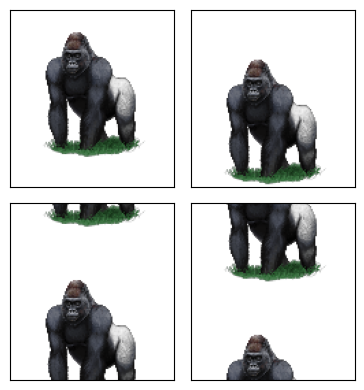

In [2]:
' Generate dataset - translated gorillas '

# Open image file and resize
img = plt.imread('data/gorilla.png')
img = img[::7, ::7, 0:3]  # select 1 every 7 pixels
img = img[7:137, 9:130]  # center image
nx, ny, _ = np.shape(img)
print('The RGB image has shape', np.shape(img))

# Translate image and flatten
X = [np.roll(img, i, 0).flatten() for i in range(nx)]
print('The point cloud (collection of translated images) has shape', np.shape(X))

# Plot a few images
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(4, 4), tight_layout=True)
axs[0, 0].imshow(X[0].reshape(np.shape(img)))
axs[0, 1].imshow(X[20].reshape(np.shape(img)))
axs[1, 0].imshow(X[40].reshape(np.shape(img)))
axs[1, 1].imshow(X[80].reshape(np.shape(img)))
for ax in list(axs.flatten()):
    ax.set_xticks([])
    ax.set_yticks([])
fig.savefig('figures/gorilla_translation_SO(2)_sample.png', dpi=fig.dpi, bbox_inches='tight')

Covariance eigenvalues: 4.0e-01  4.0e-01  4.2e-02  4.2e-02  3.1e-02  3.1e-02  2.5e-02  2.5e-02 
Mean distance to origin: 1.0e+00 ± 4.7e-09
Lie PCA first eigenvalues: 3.7e-19  3.6e-02  3.6e-02  7.0e-02  Eigengap #1: 9.7e+16.


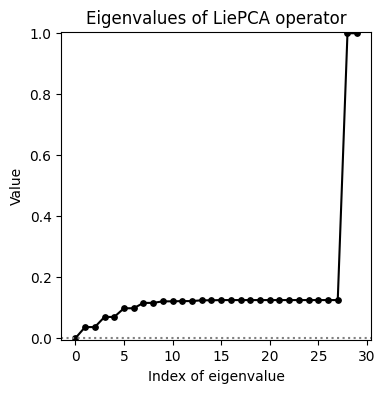

In [3]:
' Dimension reduction '

# Project in lower dimension via PCA and show eigenvalues
dim_pca = 8
Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
print_covariance_eigenvalues(Y)

Y, Cov = orthonormalize(Y)
print_norms(Y)

' LiePCA '

n_neighbors = 10
dim_LiePCA = 1
Sigma = get_lie_pca_operator(Y, n_neighbors, dim_LiePCA, method='PCA', verbose=True)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[:30]
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot()
ax.plot(range(len(vals)), vals, c='black')
ax.scatter(range(len(vals)), vals, c='black', s=15)
ax.axhline(0, color='grey', linestyle='dotted')
ax.set_ylim((0 - 0.005, max(vals) + 0.005))
ax.set_title('Eigenvalues of LiePCA operator')
ax.set_xlabel('Index of eigenvalue')
ax.set_ylabel('Value')
plt.show()
fig.savefig('figures/gorilla_translation_SO(2)_LiePCA.png', dpi=fig.dpi, bbox_inches='tight');

----> Optimization problem via abelian method for torus  <----
The optimal rep found is ((1, 2, 3, 4),) with cost 3.432e-02.
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 0.00861217597278653 
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.06609640155599268


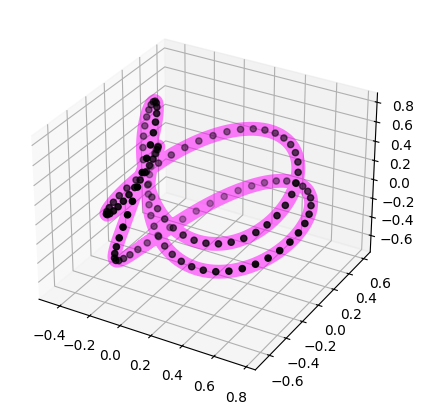

In [4]:
' LieDetect '

group, dim = 'torus', 1
ambient_dim = dim_pca
method_optim, frequency_max = 'abelian', 10
OptimalFrequencies, OptimalLieAlgebra = find_closest_algebra(group, Sigma, dim, frequency_max=frequency_max,
                                                             method=method_optim, verbose=True)

' Generate orbit and plot '

# Generate estimated orbit
n_points_orbit = 1000
x = Y[0, :]  #initial point of X
Orbit = sample_orbit_from_algebra(group=group, rep_type=OptimalFrequencies, algebra=OptimalLieAlgebra, x=x,
                                  nb_points=n_points_orbit, method="uniform", )

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
print('\x1b[1;31m' + 'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff, '\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Ypca = pca.fit_transform(Y)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(Ypca[:, 0], Ypca[:, 1], Ypca[:, 2], c='black')
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:, 0], Orbitpca[:, 1], Orbitpca[:, 2], c='magenta', lw=10, alpha=0.5)
fig.savefig('figures/gorilla_translation_SO(2)_orbit.png', dpi=fig.dpi, bbox_inches='tight')

In [5]:
' Repeat the experiment for several embedding dimensions '

Scores = list()

for dim_pca in range(2, 26 + 2, 2):
    # Dimension reduction
    Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
    Y, _ = orthonormalize(Y)

    # LiePCA
    n_neighbors = 2
    # n_neighbors = 10
    dim_LiePCA = 1
    Sigma = get_lie_pca_operator(pts=Y, nb_neighbors=n_neighbors, orbit_dim=dim_LiePCA, method="PCA", verbose=False)

    # LieDetect
    group, dim = 'torus', 1
    ambient_dim = dim_pca
    method_optim, frequency_max = 'abelian', 20
    OptimalFrequencies, OptimalLieAlgebra = find_closest_algebra(group=group, lie_pca=Sigma, group_dim=dim,
                                                                 frequency_max=frequency_max, span_ambient_space=True,
                                                                 method=method_optim, verbose=True)

    # Generate orbit
    n_points_orbit = 1000
    x = Y[0, :]  #initial point of X
    Orbit = sample_orbit_from_algebra(group=group, rep_type=OptimalFrequencies, algebra=OptimalLieAlgebra, x=x,
                                      nb_points=n_points_orbit, method="uniform", )
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
    print('\x1b[1;31m' + 'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff, '\x1b[0m')

    Scores.append([dim_pca, OptimalFrequencies, Hausdorff])

# Print scores in markdown and latex
IPython.display.clear_output()
str_markdown = '| Ambient dimension | Representation found | Hausdorff distance |\n| --- | --- | --- |\n' + '\n'.join(
    [str(score[0]) + '|' + str(score[1][0]) + '|' + '{:.4f}'.format(score[2]) + '|' for score in Scores])
IPython.display.display_markdown(str_markdown, raw=True)
str_latex = '\\begin{longtable}{||c|l|c||}\\hline\\begin{tabular}{@{}c@{}}Ambient\\\\dimension\\end{tabular}&Representation found&\\begin{tabular}{@{}c@{}}Haudorff\\\\distance\\end{tabular}\\\\*\\hline' + '\\\\'.join(
    [str(score[0]) + '&' + str(score[1][0]) + '&' + '{:.4f}'.format(score[2]) for score in
     Scores]) + '\\\\*\\hline\\end{longtable}'
print(str_latex)

| Ambient dimension | Representation found | Hausdorff distance |
| --- | --- | --- |
2|(1,)|0.0031|
4|(1, 2)|0.0050|
6|(1, 2, 3)|0.0068|
8|(1, 2, 3, 4)|0.0086|
10|(1, 2, 3, 4, 5)|0.0104|
12|(1, 2, 3, 4, 5, 6)|0.0122|
14|(1, 2, 3, 4, 5, 6, 8)|0.0148|
16|(1, 2, 3, 4, 5, 6, 7, 8)|0.0158|
18|(1, 2, 3, 4, 5, 6, 7, 8, 10)|0.0180|
20|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)|0.0211|
22|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)|0.0788|
24|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)|0.1168|
26|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)|0.5671|

\begin{longtable}{||c|l|c||}\hline\begin{tabular}{@{}c@{}}Ambient\\dimension\end{tabular}&Representation found&\begin{tabular}{@{}c@{}}Haudorff\\distance\end{tabular}\\*\hline2&(1,)&0.0031\\4&(1, 2)&0.0050\\6&(1, 2, 3)&0.0068\\8&(1, 2, 3, 4)&0.0086\\10&(1, 2, 3, 4, 5)&0.0104\\12&(1, 2, 3, 4, 5, 6)&0.0122\\14&(1, 2, 3, 4, 5, 6, 8)&0.0148\\16&(1, 2, 3, 4, 5, 6, 7, 8)&0.0158\\18&(1, 2, 3, 4, 5, 6, 7, 8, 10)&0.0180\\20&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)&0.0211\\22&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)&0.0788\\24&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)&0.1168\\26&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)&0.5671\\*\hline\end{longtable}


## I.2. $T^2$-action on translated gorillas

The RGB image has shape (130, 120, 3)
The point cloud (collection of translated images) has shape (3900, 46800)


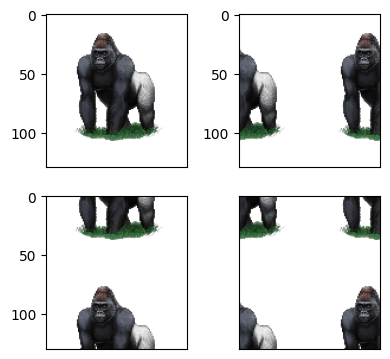

In [6]:
' Generate dataset - translated gorillas '

# Open image file and resize
img = plt.imread('data/gorilla.png')
img = img[::7, ::7, 0:3]  # select 1 every 7 pixels
img = img[7:137, 9:130]  # center image
nx, ny, _ = np.shape(img)
print('The RGB image has shape', np.shape(img))

# Translate image and flatten
X = [np.roll(np.roll(img, i, 0), j, 1).flatten() for i in range(0, nx, 2) for j in range(0, ny, 2)]
print('The point cloud (collection of translated images) has shape', np.shape(X))

# Plot a few images
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(4, 4), tight_layout=True)
axs[0, 0].imshow(X[0].reshape(np.shape(img)))
axs[0, 1].imshow(X[30].reshape(np.shape(img)))
axs[1, 0].imshow(X[1800].reshape(np.shape(img)))
axs[1, 1].imshow(X[1830].reshape(np.shape(img)))
for ax in list(axs.flatten()):
    ax.set_xticks([])
ax.set_yticks([])
fig.savefig('figures/gorilla_translation_T2_sample.png', dpi=fig.dpi, bbox_inches='tight')

Covariance eigenvalues: 2.3e-01  2.3e-01  1.4e-01  1.4e-01  1.1e-01  1.1e-01  2.2e-02  2.2e-02 
Mean distance to origin: 1.0e+00 ± 4.9e-05
Lie PCA first eigenvalues: 5.9e-09  2.2e-08  4.1e-02  4.1e-02  Eigengap #2: 1.9e+06.


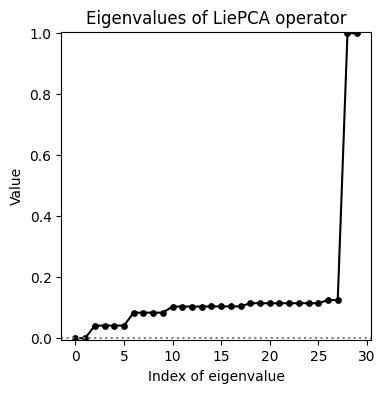

In [7]:
' Dimension reduction '

# Project in lower dimension via PCA and show eigenvalues
dim_pca = 8
Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
print_covariance_eigenvalues(Y)

Y, Cov = orthonormalize(Y)
print_norms(Y)

' LiePCA '

n_neighbors = 50
dim_LiePCA = 2
Sigma = get_lie_pca_operator(Y, n_neighbors, dim_LiePCA, method='PCA', verbose=True)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[:30]  #find eigenvalues and vectors of sigma as a matrix
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot()
ax.plot(range(len(vals)), vals, c='black')
ax.scatter(range(len(vals)), vals, c='black', s=15)
ax.axhline(0, color='grey', linestyle='dotted')
ax.set_ylim((0 - 0.005, max(vals) + 0.005))
ax.set_title('Eigenvalues of LiePCA operator')
ax.set_xlabel('Index of eigenvalue')
ax.set_ylabel('Value')
fig.savefig('figures/gorilla_translation_T2_LiePCA.png', dpi=fig.dpi, bbox_inches='tight')

----> Optimization problem via abelian method for torus  <----
The optimal rep found is ((0, 1, 1, -1), (-1, 0, 1, -2)) with cost 1.244e-02.
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 0.025582548070404127 
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.061320965239764755


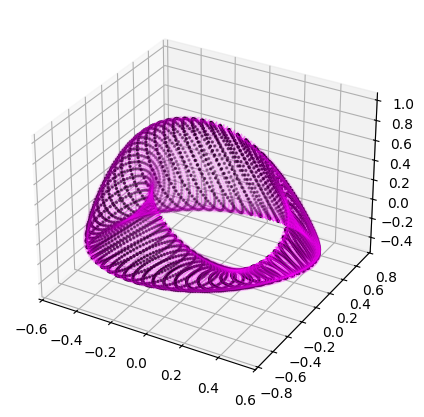

In [8]:
' LieDetect '

group, dim = 'torus', 2
ambient_dim = dim_pca
method_optim, frequency_max = 'abelian', 2
OptimalFrequencies, OptimalLieAlgebra = find_closest_algebra(group, Sigma, dim, frequency_max=frequency_max,
                                                             method=method_optim, verbose=True)

' Generate orbit and plot '

# Generate estimated orbit
n_points_orbit = 150 ** 2
x = Y[0, :]  #initial point
Orbit = sample_orbit_from_algebra(group=group, rep_type=OptimalFrequencies, algebra=OptimalLieAlgebra, x=x,
                                  nb_points=n_points_orbit, method="uniform", )

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
print('\x1b[1;31m' + 'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff, '\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Ypca = pca.fit_transform(Y)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(Ypca[:, 0], Ypca[:, 1], Ypca[:, 2], c='black', s=2)
Orbitpca = pca.transform(Orbit)
ax.scatter(Orbitpca[:, 0], Orbitpca[:, 1], Orbitpca[:, 2], c='magenta', lw=0.5, alpha=0.1, marker="3")
fig.savefig('figures/gorilla_translation_T2_orbit.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

In [9]:
' Repeat the experiment for several embedding dimensions '

Scores = list()

for dim_pca in range(4, 14 + 2, 2):
    # Dimension reduction
    Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
    Y, _ = orthonormalize(Y)

    # LiePCA
    n_neighbors = 50
    dim_LiePCA = 2
    Sigma = get_lie_pca_operator(Y, n_neighbors, dim_LiePCA, method='PCA', verbose=False)

    # LieDetect
    group, dim = 'torus', 2
    ambient_dim = dim_pca
    method_optim, frequency_max = 'abelian', 2
    OptimalFrequencies, OptimalLieAlgebra = find_closest_algebra(group, Sigma, dim, frequency_max=frequency_max,
                                                                 method=method_optim, verbose=True)

    # Generate orbit
    n_points_orbit = 150 ** 2
    x = Y[0, :]  #initial point
    Orbit = sample_orbit_from_algebra(group, OptimalFrequencies, OptimalLieAlgebra, nb_points=n_points_orbit, x=x,
                                      method='uniform')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
    print('\x1b[1;31m' + 'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff, '\x1b[0m')

    Scores.append([dim_pca, OptimalFrequencies, Hausdorff])

# Print scores in markdown and latex
IPython.display.clear_output()
str_markdown = '| Ambient dimension | Representation found | Hausdorff distance |\n| --- | --- | --- |\n' + '\n'.join(
    [str(score[0]) + '|' + str(score[1]) + '|' + '{:.4f}'.format(score[2]) + '|' for score in Scores])
IPython.display.display_markdown(str_markdown, raw=True)
str_latex = '\\begin{longtable}{||c|l|c||}\\hline\\begin{tabular}{@{}c@{}}Ambient\\\\dimension\\end{tabular}&Representation found&\\begin{tabular}{@{}c@{}}Haudorff\\\\distance\\end{tabular}\\\\*\\hline' + '\\\\'.join(
    [str(score[0]) + '&' + str(score[1]) + '&' + '{:.4f}'.format(score[2]) for score in
     Scores]) + '\\\\*\\hline\\end{longtable}'
print(str_latex)

| Ambient dimension | Representation found | Hausdorff distance |
| --- | --- | --- |
4|((0, -1), (-1, 0))|0.0209|
6|((-1, -1, 0), (0, -1, -1))|0.0197|
8|((-1, -1, 0, -1), (-2, 0, -1, -1))|0.0256|
10|((0, -1, -1, 0, -1), (2, 0, -2, -1, -1))|0.0303|
12|((-1, 1, -1, 0, 2, 2), (-2, 0, -1, -1, 2, 1))|0.0870|
14|((-1, -2, 0, 2, 0, -1, -1), (0, -2, -1, 1, -2, -1, -2))|0.8150|

\begin{longtable}{||c|l|c||}\hline\begin{tabular}{@{}c@{}}Ambient\\dimension\end{tabular}&Representation found&\begin{tabular}{@{}c@{}}Haudorff\\distance\end{tabular}\\*\hline4&((0, -1), (-1, 0))&0.0209\\6&((-1, -1, 0), (0, -1, -1))&0.0197\\8&((-1, -1, 0, -1), (-2, 0, -1, -1))&0.0256\\10&((0, -1, -1, 0, -1), (2, 0, -2, -1, -1))&0.0303\\12&((-1, 1, -1, 0, 2, 2), (-2, 0, -1, -1, 2, 1))&0.0870\\14&((-1, -2, 0, 2, 0, -1, -1), (0, -2, -1, 1, -2, -1, -2))&0.8150\\*\hline\end{longtable}


## I.3. $\mathrm{SO}(2)$-action on rotated gorillas

The RGB image has shape (130, 120, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0594908..1.1517092].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05296135..1.1479323].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.059629083..1.1470596].


The point cloud (collection of rotated images) has shape (360, 46800)


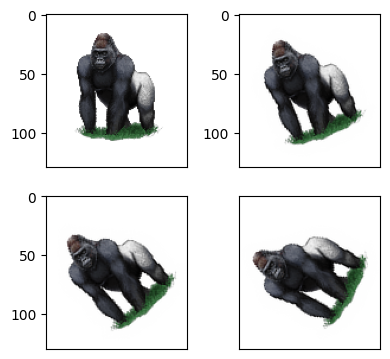

In [10]:
' Generate dataset - rotated gorillas '

# Open image file and resize
img = plt.imread('data/gorilla.png')
img = img[::7, ::7, 0:3]  # select 1 every 7 pixels
img = img[7:137, 9:130]  # center image
nx, ny, _ = np.shape(img)
print('The RGB image has shape', np.shape(img))

# Translate image and flatten
X = [1 - scipy.ndimage.rotate(1 - img, i, reshape=False).flatten() for i in range(360)]
print('The point cloud (collection of rotated images) has shape', np.shape(X))

# Plot a few images
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(4, 4), tight_layout=True)
axs[0, 0].imshow(X[0].reshape(np.shape(img)))
axs[0, 1].imshow(X[20].reshape(np.shape(img)))
axs[1, 0].imshow(X[40].reshape(np.shape(img)))
axs[1, 1].imshow(X[60].reshape(np.shape(img)))
for ax in list(axs.flatten()):
    ax.set_xticks([])
ax.set_yticks([])
fig.savefig('figures/gorilla_rotation_sample.png', dpi=fig.dpi, bbox_inches='tight')

Covariance eigenvalues: 1.6e-01  1.6e-01  1.1e-01  1.1e-01  4.1e-02  4.1e-02  4.0e-02  4.0e-02  3.8e-02  3.8e-02  2.6e-02  2.6e-02  2.0e-02  2.0e-02  1.4e-02  1.4e-02  1.3e-02  1.3e-02  1.0e-02  1.0e-02  9.4e-03  9.3e-03  8.1e-03  8.1e-03  5.2e-03  5.2e-03  4.4e-03  4.4e-03  3.4e-03  3.4e-03  3.2e-03  3.2e-03 
Mean distance to origin: 1.0e+00 ± 1.2e-03
Lie PCA first eigenvalues: 8.4e-06  2.7e-03  2.8e-03  5.3e-03  Eigengap #1: 3.2e+02.


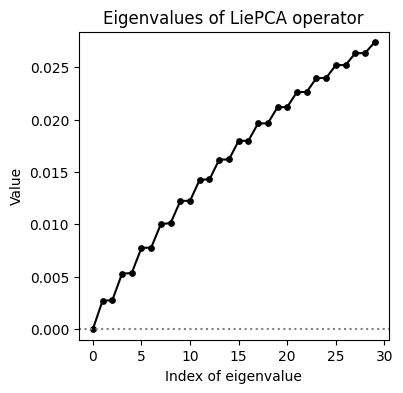

In [11]:
' Dimension reduction '

# Project in lower dimension via PCA and show eigenvalues
dim_pca = 32
Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
print_covariance_eigenvalues(Y)

# Orthonormalize
Y, Cov = orthonormalize(Y)
print_norms(Y)

' LiePCA '

n_neighbors = 2
dim_LiePCA = 1
Sigma = get_lie_pca_operator(Y, n_neighbors, dim_LiePCA, method='PCA', verbose=True)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[:30]  #find eigenvalues and vectors of sigma as a matrix
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot()
ax.plot(range(len(vals)), vals, c='black')
ax.scatter(range(len(vals)), vals, c='black', s=15)
ax.axhline(0, color='grey', linestyle='dotted')
ax.set_ylim((0 - 0.001, max(vals) + 0.001))
ax.set_title('Eigenvalues of LiePCA operator')
ax.set_xlabel('Index of eigenvalue')
ax.set_ylabel('Value')
fig.savefig('figures/gorilla_rotation_LiePCA.png', dpi=fig.dpi, bbox_inches='tight')

----> Optimization problem via abelian method for torus  <----
The optimal rep found is ((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16),) with cost 3.696e-03.
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 0.03762222717268985 
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.08670938277050301
Typical distance between points: 0.17102056259941517


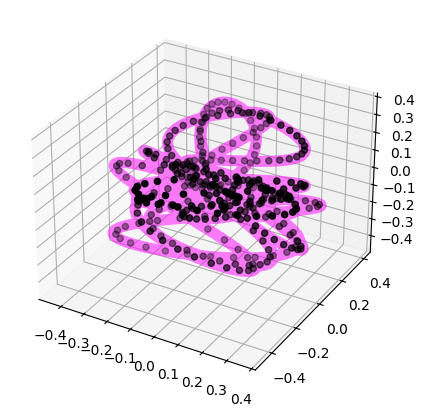

In [12]:
' LieDetect '

group, dim = 'torus', 1
ambient_dim = dim_pca
method_optim, frequency_max = 'abelian', 20
OptimalFrequencies, OptimalLieAlgebra = find_closest_algebra(group, Sigma, dim, frequency_max=frequency_max,
                                                             method=method_optim, verbose=True)

' Generate orbit and plot '

# Generate estimated orbit
n_points_orbit = 1000
x = Y[0, :]  #initial point of X
Orbit = sample_orbit_from_algebra(group, OptimalFrequencies, OptimalLieAlgebra, nb_points=n_points_orbit, x=x,
                                  method='uniform')

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
print('\x1b[1;31m' + 'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff, '\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Ypca = pca.fit_transform(Y)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(Ypca[:, 0], Ypca[:, 1], Ypca[:, 2], c='black')
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:, 0], Orbitpca[:, 1], Orbitpca[:, 2], c='magenta', lw=8, alpha=0.5)
fig.savefig('figures/gorilla_rotation_orbit.png', dpi=fig.dpi, bbox_inches='tight')

# Typical distance between points
print('Typical distance between points:',
      max([np.linalg.norm(Y[i, :] - Y[i + 1, :]) for i in range(np.shape(Y)[0] - 1)]))

In [13]:
' Repeat the experiment for several embedding dimensions '

Scores = list()

for dim_pca in range(2, 34 + 2, 2):
    # Dimension reduction
    Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
    Y, _ = orthonormalize(Y)

    # LiePCA
    n_neighbors = 2
    dim_LiePCA = 1
    Sigma = get_lie_pca_operator(Y, n_neighbors, dim_LiePCA, method='PCA', verbose=False)

    # LieDetect
    group, dim = 'torus', 1
    ambient_dim = dim_pca
    method_optim, frequency_max = 'abelian', 25
    OptimalFrequencies, OptimalLieAlgebra = find_closest_algebra(group, Sigma, dim, frequency_max=frequency_max,
                                                                 method=method_optim, verbose=True)

    # Generate orbit
    n_points_orbit = 1000
    x = Y[0, :]  #initial point of X
    Orbit = sample_orbit_from_algebra(group, OptimalFrequencies, OptimalLieAlgebra, nb_points=n_points_orbit, x=x,
                                      method='uniform')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
    print('\x1b[1;31m' + 'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff, '\x1b[0m')

    Scores.append([dim_pca, OptimalFrequencies, Hausdorff])

# Print scores in markdown and latex
IPython.display.clear_output()
str_markdown = '| Ambient dimension | Representation found | Hausdorff distance |\n| --- | --- | --- |\n' + '\n'.join(
    [str(score[0]) + '|' + str(score[1][0]) + '|' + '{:.4f}'.format(score[2]) + '|' for score in Scores])
IPython.display.display_markdown(str_markdown, raw=True)
str_latex = '\\begin{longtable}{||c|l|c||}\\hline\\begin{tabular}{@{}c@{}}Ambient\\\\dimension\\end{tabular}&Representation found&\\begin{tabular}{@{}c@{}}Haudorff\\\\distance\\end{tabular}\\\\*\\hline' + '\\\\'.join(
    [str(score[0]) + '&' + str(score[1][0]) + '&' + '{:.4f}'.format(score[2]) for score in
     Scores]) + '\\\\*\\hline\\end{longtable}'
print(str_latex)

| Ambient dimension | Representation found | Hausdorff distance |
| --- | --- | --- |
2|(1,)|0.0032|
4|(1, 2)|0.0050|
6|(1, 2, 5)|0.0100|
8|(1, 2, 5, 6)|0.0128|
10|(1, 2, 4, 5, 6)|0.0128|
12|(1, 2, 3, 4, 5, 6)|0.0124|
14|(1, 2, 3, 4, 5, 6, 7)|0.0141|
16|(1, 2, 3, 4, 5, 6, 7, 11)|0.0181|
18|(1, 2, 3, 4, 5, 6, 7, 9, 11)|0.0195|
20|(1, 2, 3, 4, 5, 6, 7, 8, 9, 11)|0.0203|
22|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)|0.0215|
24|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)|0.0235|
26|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14)|0.0258|
28|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)|0.0283|
30|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)|0.0378|
32|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)|0.0714|
34|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18)|0.0448|

\begin{longtable}{||c|l|c||}\hline\begin{tabular}{@{}c@{}}Ambient\\dimension\end{tabular}&Representation found&\begin{tabular}{@{}c@{}}Haudorff\\distance\end{tabular}\\*\hline2&(1,)&0.0032\\4&(1, 2)&0.0050\\6&(1, 2, 5)&0.0100\\8&(1, 2, 5, 6)&0.0128\\10&(1, 2, 4, 5, 6)&0.0128\\12&(1, 2, 3, 4, 5, 6)&0.0124\\14&(1, 2, 3, 4, 5, 6, 7)&0.0141\\16&(1, 2, 3, 4, 5, 6, 7, 11)&0.0181\\18&(1, 2, 3, 4, 5, 6, 7, 9, 11)&0.0195\\20&(1, 2, 3, 4, 5, 6, 7, 8, 9, 11)&0.0203\\22&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)&0.0215\\24&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)&0.0235\\26&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14)&0.0258\\28&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)&0.0283\\30&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)&0.0378\\32&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)&0.0714\\34&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18)&0.0448\\*\hline\end{longtable}


# II. Rotation of 3D objects

In [14]:
def Cloud2Voxels(points, x, y, z, ):
    # Locate points in voxelized grid
    img = np.zeros((len(x), len(y), len(z)))
    for point in points:
        img[np.where(x <= point[0])[0][-1], np.where(y <= point[1])[0][-1], np.where(z <= point[2])[0][-1]] += 1
    return img


def MakeDatasetFromMesh(name='armadillo', method_data='voxels', N_img=1000, N_points=1000, N_voxels=20, bw=.25,
                        plot=False, return_Rotations=False):
    X = []
    if return_Rotations:
        arrow = np.array([[0], [1], [0]])  # Head of armadillo
        Rotations, Directions, Angles = [], [], []

    # Generate initial mesh
    if name == 'armadillo':
        mesh = o3d.io.read_triangle_mesh(o3d.data.ArmadilloMesh().path)
    elif name == 'avocado':
        mesh = o3d.io.read_triangle_mesh(o3d.data.AvocadoModel().path)
    elif name == 'bunny':
        mesh = o3d.io.read_triangle_mesh(o3d.data.BunnyMesh().path)
    elif name == 'helmet':
        mesh = o3d.io.read_triangle_mesh(o3d.data.FlightHelmetModel().path)
    elif name == 'knot':
        mesh = o3d.io.read_triangle_mesh(o3d.data.KnotMesh().path)
    elif name == 'monkey':
        mesh = o3d.io.read_triangle_mesh(o3d.data.MonkeyModel().path)

    if method_data == 'mesh':
        voxel_size = 2 / N_voxels

        # Center and fit to unit ball
        mesh.translate(-mesh.get_center())
        mesh.scale(1 / max(np.linalg.norm(np.array(mesh.vertices), axis=1)), mesh.get_center())

        # Simplify mesh
        mesh = mesh.simplify_vertex_clustering(voxel_size=0.025,
                                               contraction=o3d.geometry.SimplificationContraction.Average)

    if method_data in ['voxels', 'kde']:
        # Sample points and rescale to unit sphere
        points = np.array(mesh.sample_points_poisson_disk(N_points).points)
        mb = miniball.get_bounding_ball(points)
        points -= mb[0]
        points /= np.sqrt(mb[1])
        x, y, z = np.linspace(-1, 1, N_voxels), np.linspace(-1, 1, N_voxels), np.linspace(-1, 1, N_voxels)

    if method_data == 'voxels':
        # Define initial image (for 'voxels')
        img = Cloud2Voxels(points, x, y, z)

    if method_data == 'kde':
        # Define meshgrid
        space = [x, y, z]
        grid = np.meshgrid(*space)
        coords = np.vstack(list(map(np.ravel, grid)))

    # Generate data
    msg = 'Compute voxel data... '
    for i in range(N_img):
        if method_data == 'mesh':
            if i == 0:  #initial image, no rotation
                O = np.eye(3)
            else:
                O = scipy.stats.special_ortho_group.rvs(3)
            mesh.rotate(O)
            voxels_list = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=voxel_size).get_voxels()
            voxels_indices = np.stack(list(vx.grid_index for vx in voxels_list))
            img_rot = np.zeros((N_voxels, N_voxels, N_voxels))
            img_rot[voxels_indices[:, 0], voxels_indices[:, 1], voxels_indices[:, 2]] = 1

        if method_data == 'voxels':
            if i == 0:  #initial image, no rotation
                angle01, angle02, angle12 = 0, 0, 0
            else:
                angle01, angle02, angle12 = np.random.rand(3) * 360
            img_rot = scipy.ndimage.rotate(img, angle01, axes=(0, 1), reshape=False)
            img_rot = scipy.ndimage.rotate(img_rot, angle02, axes=(0, 2), reshape=False)
            img_rot = scipy.ndimage.rotate(img_rot, angle12, axes=(1, 2), reshape=False)
            O = scipy.spatial.transform.Rotation.from_euler('xyz', [angle01, angle02, angle12],
                                                            degrees=True).as_matrix()

        if method_data == 'kde':
            if i == 0:  #initial image, no rotation
                O = np.eye(3)
            else:
                O = scipy.stats.special_ortho_group.rvs(3)
            points_orth = np.array([O.dot(point) for point in points])
            points_orth_list = [p for p in points_orth.T]
            kde = scipy.stats.gaussian_kde(points_orth_list, bw_method=bw)
            img_rot = kde(coords)

        if return_Rotations:
            Rotations.append(O)
            Directions.append(O @ arrow)
            Angles.append(np.min(np.real(np.linalg.eig(O)[0])))

        X.append(img_rot.flatten())

    X = np.array(X)
    print('Count (min/max):', np.min(np.sum(X, 1)), np.max(np.sum(X, 1)))
    print('Count ticks (min/max):', np.min(np.sum(X > 0, 1)), np.max(np.sum(X > 0, 1)))

    # Center, normalize pointwise, and reduce dim
    X -= np.mean(X, 0)
    X = np.array([p / np.linalg.norm(p) for p in X])
    X = sklearn.decomposition.PCA(n_components=20).fit_transform(X)

    if plot:
        # Plot PCA point cloud
        fig = plt.figure(figsize=(4, 4))
        ax = fig.add_subplot(projection='3d')
        Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
        ax.scatter(Xpca[:, 0], Xpca[:, 1], Xpca[:, 2], c='black', s=5)
        plt.show()

        # Show last voxel image
        ax = plt.figure(figsize=(4, 4)).add_subplot(projection='3d')
        if method_data == 'mesh':
            ax.voxels(img_rot > 0.1, color='black')
        if method_data == 'voxels':
            ax.voxels(img_rot > 0.1, color='black')
            # ax.scatter(points[:,0], points[:,1], points[:,2], c='black');
            ax.view_init(-125, +25)
        if method_data == 'kde':
            kde_img = img_rot.reshape((N_voxels, N_voxels, N_voxels))
            colors = np.zeros((N_voxels, N_voxels, N_voxels, 4))
            for i in range(4): colors[:, :, :, i] = kde_img / np.max(kde_img)
            ax.voxels(kde_img > 0.1, facecolors=colors)
        plt.show()

    if return_Rotations:
        # Turn list into numpy arrays
        Rotations = np.array(Rotations)
        Rotations = Rotations.reshape(Rotations.shape[0], Rotations.shape[1] * Rotations.shape[2])
        Directions = np.array(Directions)
        Directions = Directions[:, :, 0]
        Angles = np.array(Angles)

    if return_Rotations:
        return X, Rotations, Directions, Angles
    else:
        return X

## II.1. $\mathrm{SO}(3)$-action on armadillo in $\mathbb{R}^8$

### II.1.1. Illustrate the different rotation methods

Rotation method: mesh


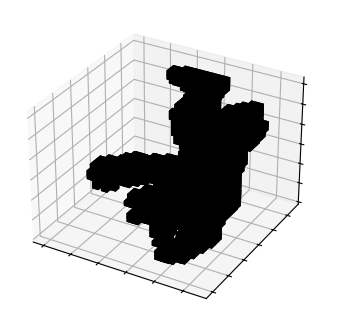

Rotation method: voxels


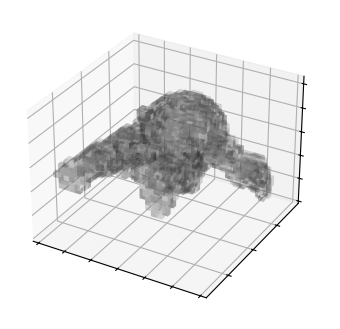

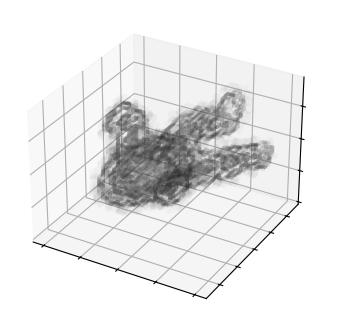

Rotation method: kde


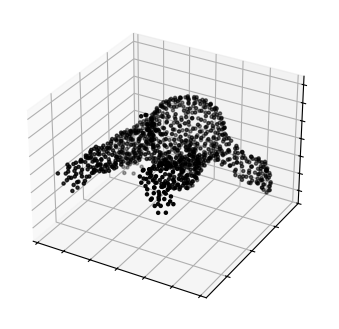

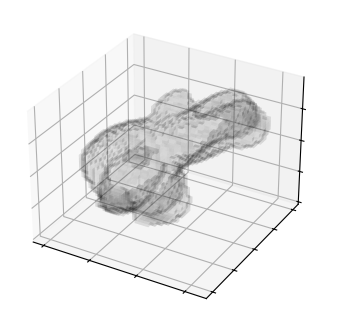

In [15]:
N_voxels = 40
x, y, z = np.linspace(-1, 1, N_voxels), np.linspace(-1, 1, N_voxels), np.linspace(-1, 1, N_voxels)

' Illustrate rotation method: mesh '

method_data = 'mesh'
bw = .25
N_points = 1000
print('Rotation method:', method_data)

# Generate data
mesh = o3d.io.read_triangle_mesh(o3d.data.ArmadilloMesh().path)
voxel_size = 2 / N_voxels
mesh.translate(-mesh.get_center())
mesh.scale(1 / max(np.linalg.norm(np.array(mesh.vertices), axis=1)), mesh.get_center())
mesh = mesh.simplify_vertex_clustering(voxel_size=0.025, contraction=o3d.geometry.SimplificationContraction.Average)

# Plot rotated image
O = scipy.stats.special_ortho_group.rvs(3)
mesh.rotate(O)
voxels_list = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=voxel_size).get_voxels()
voxels_indices = np.stack(list(vx.grid_index for vx in voxels_list))
img_rot = np.zeros((N_voxels, N_voxels, N_voxels))
img_rot[voxels_indices[:, 0], voxels_indices[:, 1], voxels_indices[:, 2]] = 1
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')
ax.voxels(img_rot > 0.1, color='black')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
fig.savefig('figures/rotation_method_' + method_data + '_rotated.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

' Illustrate rotation method: voxels '

method_data = 'voxels'
N_points = 10000
print('Rotation method:', method_data)

# Generate data
mesh = o3d.io.read_triangle_mesh(o3d.data.ArmadilloMesh().path)
points = np.array(mesh.sample_points_poisson_disk(N_points).points)
mb = miniball.get_bounding_ball(points)
points -= mb[0]
points /= np.sqrt(mb[1])

# Plot initial image
img = Cloud2Voxels(points, x, y, z)
colors = np.zeros((N_voxels, N_voxels, N_voxels, 4))
for i in range(4): colors[:, :, :, i] = np.abs(img / np.max(img))
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')
ax.voxels(img > 0.1, facecolors=colors, shade=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
fig.savefig('figures/rotation_method_' + method_data + '_initial.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

# Plot rotated image
angle01, angle02, angle12 = np.random.rand(3) * 360
img_rot = scipy.ndimage.rotate(img, angle01, axes=(0, 1), reshape=False)
img_rot = scipy.ndimage.rotate(img_rot, angle02, axes=(0, 2), reshape=False)
img_rot = scipy.ndimage.rotate(img_rot, angle12, axes=(1, 2), reshape=False)
colors = np.zeros((N_voxels, N_voxels, N_voxels, 4))
for i in range(4): colors[:, :, :, i] = np.abs(img_rot / np.max(img_rot))
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')
ax.voxels(img_rot > 0.1, facecolors=colors, shade=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
fig.savefig('figures/rotation_method_' + method_data + '_rotated.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

' Illustrate rotation method: kde '

method_data = 'kde'
bw = .25
N_points = 1000
print('Rotation method:', method_data)

# Generate data
mesh = o3d.io.read_triangle_mesh(o3d.data.ArmadilloMesh().path)
points = np.array(mesh.sample_points_poisson_disk(N_points).points)
mb = miniball.get_bounding_ball(points)
points -= mb[0]
points /= np.sqrt(mb[1])

# Plot initial image
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='black', s=5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
fig.savefig('figures/rotation_method_' + method_data + '_initial.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

# Plot rotated image
space = [x, y, z]
grid = np.meshgrid(*space)
coords = np.vstack(list(map(np.ravel, grid)))
O = scipy.stats.special_ortho_group.rvs(3)
points_orth = np.array([O.dot(point) for point in points])
points_orth_list = [p for p in points_orth.T]
kde = scipy.stats.gaussian_kde(points_orth_list, bw_method=bw)
img_rot = kde(coords)
kde_img = img_rot.reshape((N_voxels, N_voxels, N_voxels))
colors = np.zeros((N_voxels, N_voxels, N_voxels, 4))
for i in range(4): colors[:, :, :, i] = kde_img / np.max(kde_img)
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')
ax.voxels(kde_img > 0.1, facecolors=colors)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
fig.savefig('figures/rotation_method_' + method_data + '_rotated.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

### II.1.2. Orbit detection with 'mesh' method

Count (min/max): 491.0 557.0
Count ticks (min/max): 491 557
Covariance eigenvalues: 2.1e-01  2.0e-01  1.7e-01  9.0e-02  8.7e-02  8.5e-02  7.7e-02  7.5e-02 
Mean distance to origin: 1.0e+00 ± 8.3e-02


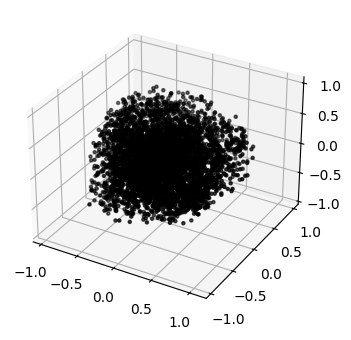

In [16]:
' Generate dataset '

name = 'armadillo'
method_data = 'mesh'
N_img = 5000
N_voxels = 20

X = MakeDatasetFromMesh(name=name, method_data=method_data, N_img=N_img, N_points=None, N_voxels=N_voxels, plot=False)

' Dimension reduction '

# Project in lower dimension via PCA and show eigenvalues
dim_pca = 8
Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
print_covariance_eigenvalues(Y)

# Center and normalize
Y -= np.mean(Y, 0)
Y = np.array([p / np.linalg.norm(p) for p in Y])
Y, Cov = orthonormalize(Y)
print_norms(Y)

# Plot point cloud
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')
Ypca = sklearn.decomposition.PCA(n_components=3).fit_transform(Y)
ax.scatter(Ypca[:, 0], Ypca[:, 1], Ypca[:, 2], c='black', s=5)
plt.show()

Lie PCA first eigenvalues: 4.6e-02  4.7e-02  4.8e-02  6.4e-02  Eigengap #3: 1.3e+00.


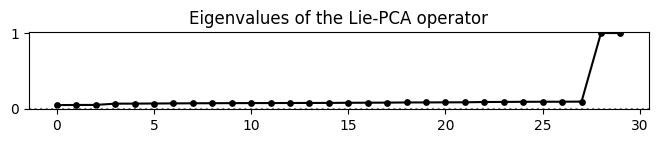

Eigengap is 1.34231379522643


In [17]:
' LiePCA '

n_neighbors = 10
dim_LiePCA = 3
Sigma = get_lie_pca_operator(Y, n_neighbors, dim_LiePCA, method='PCA', correction=True, verbose=True)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[0:30]
fig = plt.figure(figsize=(8, 1))
ax = fig.add_subplot()
ax.plot(range(len(vals)), vals, c='black')
ax.scatter(range(len(vals)), vals, c='black', s=15)
ax.axhline(0, color='grey', linestyle='dotted')
ax.set_ylim((0 - 0.01, max(vals) + 0.01))
ax.set_title('Eigenvalues of the Lie-PCA operator')
plt.show()

print('Eigengap is', vals[3] / vals[2])

----> Optimization problem via bottom_lie_pca method for SU(2)  <----
Solve minimization problem... It 1/1. Duration 0:00:00. Remaining 0:00:00.
The optimal rep found is (3, 5) with cost 2.274e-01.
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 1.0645685471711595 
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.6714576046496123


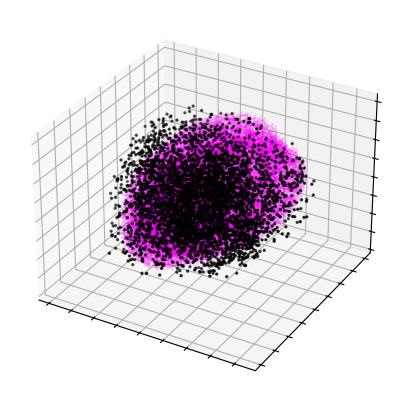

In [19]:
' LieDetect '

group, dim = 'SU(2)', 3
ambient_dim = dim_pca
FrequenciesToTest = [(3, 5)]
method_optim = 'bottom_lie_pca'
OptimalFrequencies, OptimalLieAlgebra = find_closest_algebra(group, Sigma, dim, ambient_dim,
                                                             reps_to_test=FrequenciesToTest, method=method_optim,
                                                             verbose=True)

' Generate orbit and plot '

# Generate estimated orbit
n_points_orbit = 30 ** 3
x = Y[0, :]  #initial point of X
Orbit = sample_orbit_from_algebra(group, OptimalFrequencies, OptimalLieAlgebra, nb_points=n_points_orbit, x=x)

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
print('\x1b[1;31m' + 'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff, '\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Ypca = pca.fit_transform(Y)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(Ypca[:, 0], Ypca[:, 1], Ypca[:, 2], c='black', s=2)
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:, 0], Orbitpca[:, 1], Orbitpca[:, 2], c='magenta', lw=0.5, alpha=0.1, marker="3")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
fig.savefig('figures/armadillo_orbit_' + method_data + '.png', dpi=fig.dpi, bbox_inches='tight')

### II.1.3. Orbit detection with 'voxels' method

Count (min/max): 984.4070519221391 1002.7610044972387
Count ticks (min/max): 3321 4387
Covariance eigenvalues: 2.8e-01  1.9e-01  1.8e-01  7.8e-02  7.7e-02  6.8e-02  6.2e-02  6.0e-02 
Mean distance to origin: 1.0e+00 ± 5.3e-02


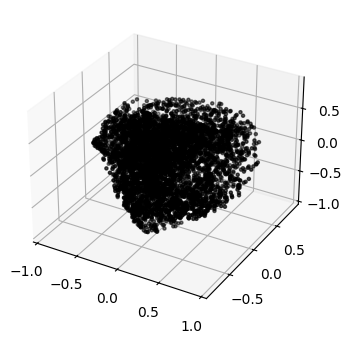

In [20]:
' Generate dataset '

name = 'armadillo'
method_data = 'voxels'
N_img = 5000
N_voxels = 20
N_points = 1000

X = MakeDatasetFromMesh(name=name, method_data=method_data, N_img=N_img, N_points=N_points, N_voxels=N_voxels,
                        plot=False)

' Dimension reduction '

# Project in lower dimension via PCA and show eigenvalues
dim_pca = 8
Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
print_covariance_eigenvalues(Y)

# Center and normalize
Y -= np.mean(Y, 0)
Y = np.array([p / np.linalg.norm(p) for p in Y])
Y, Cov = orthonormalize(Y)
print_norms(Y)

# Plot point cloud
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')
Ypca = sklearn.decomposition.PCA(n_components=3).fit_transform(Y)
ax.scatter(Ypca[:, 0], Ypca[:, 1], Ypca[:, 2], c='black', s=5)
plt.show()

Lie PCA first eigenvalues: 7.4e-03  1.0e-02  1.1e-02  4.8e-02  Eigengap #3: 4.4e+00.


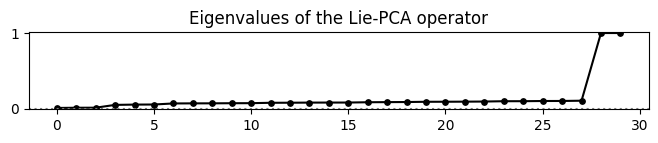

Eigengap is 4.408585861218774


In [21]:
' LiePCA '

n_neighbors = 10
dim_LiePCA = 3
Sigma = get_lie_pca_operator(Y, n_neighbors, dim_LiePCA, method='PCA', verbose=True)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[0:30]
fig = plt.figure(figsize=(8, 1))
ax = fig.add_subplot()
ax.plot(range(len(vals)), vals, c='black')
ax.scatter(range(len(vals)), vals, c='black', s=15)
ax.axhline(0, color='grey', linestyle='dotted')
ax.set_ylim((0 - 0.01, max(vals) + 0.01))
ax.set_title('Eigenvalues of the Lie-PCA operator')
plt.show()

print('Eigengap is', vals[3] / vals[2])

----> Optimization problem via bottom_lie_pca method for SU(2)  <----
Solve minimization problem... It 1/1. Duration 0:00:00. Remaining 0:00:00.
The optimal rep found is (3, 5) with cost 6.268e-03.
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 0.42372559677155447 
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.45138889395533266


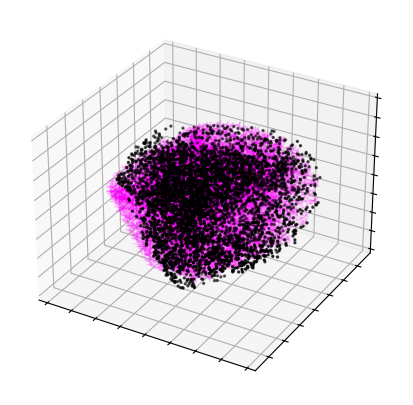

In [22]:
' LieDetect '

group, dim = 'SU(2)', 3
ambient_dim = dim_pca
FrequenciesToTest = [(3, 5)]
method_optim = 'bottom_lie_pca'
OptimalFrequencies, OptimalLieAlgebra = find_closest_algebra(group, Sigma, dim, reps_to_test=FrequenciesToTest,
                                                             method=method_optim, verbose=True)

' Generate orbit and plot '

# Generate estimated orbit
n_points_orbit = 30 ** 3
x = Y[0, :]  #initial point of X
Orbit = sample_orbit_from_algebra(group, OptimalFrequencies, OptimalLieAlgebra, nb_points=n_points_orbit, x=x)

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
print('\x1b[1;31m' + 'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff, '\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Ypca = pca.fit_transform(Y)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(Ypca[:, 0], Ypca[:, 1], Ypca[:, 2], c='black', s=2)
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:, 0], Orbitpca[:, 1], Orbitpca[:, 2], c='magenta', lw=0.5, alpha=0.1, marker="3")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
fig.savefig('figures/armadillo_orbit_' + method_data + '.png', dpi=fig.dpi, bbox_inches='tight')

### II.1.4. Orbit detection with 'kde' method

Count (min/max): 849.3355976452015 857.320332786282
Count ticks (min/max): 8000 8000
Covariance eigenvalues: 2.5e-01  2.4e-01  2.4e-01  5.6e-02  5.5e-02  5.4e-02  5.2e-02  5.1e-02 
Mean distance to origin: 1.0e+00 ± 1.9e-02


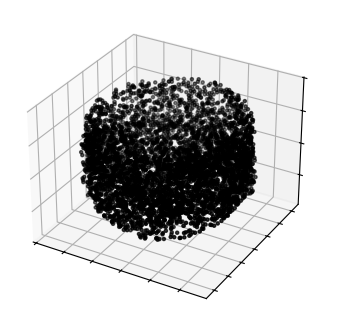

In [23]:
' Generate dataset '

name = 'armadillo'
method_data = 'kde'
N_img = 5000
N_voxels = 20
N_points = 1000
bw = .25

X = MakeDatasetFromMesh(name=name, method_data=method_data, N_img=N_img, N_voxels=N_voxels, N_points=N_points, bw=bw,
                        plot=False)

' Dimension reduction '

# Project in lower dimension via PCA and show eigenvalues
dim_pca = 8
Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
print_covariance_eigenvalues(Y)

# Center and normalize
Y -= np.mean(Y, 0)
Y = np.array([p / np.linalg.norm(p) for p in Y])
Y, Cov = orthonormalize(Y)
print_norms(Y)

# Plot point cloud
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')
Ypca = sklearn.decomposition.PCA(n_components=3).fit_transform(Y)
ax.scatter(Ypca[:, 0], Ypca[:, 1], Ypca[:, 2], c='black', s=5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.show()

Lie PCA first eigenvalues: 3.3e-03  3.5e-03  3.7e-03  5.7e-02  Eigengap #3: 1.5e+01.


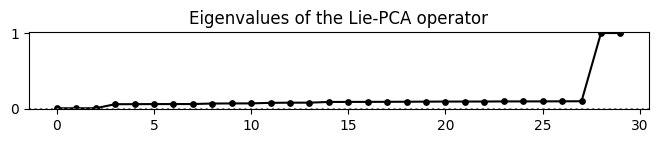

Eigengap is 15.390504811629008


In [24]:
' LiePCA '

n_neighbors = 10
dim_LiePCA = 3
Sigma = get_lie_pca_operator(Y, n_neighbors, dim_LiePCA, method='PCA', verbose=True)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[0:30]
fig = plt.figure(figsize=(8, 1))
ax = fig.add_subplot()
ax.plot(range(len(vals)), vals, c='black')
ax.scatter(range(len(vals)), vals, c='black', s=15)
ax.axhline(0, color='grey', linestyle='dotted')
ax.set_ylim((0 - 0.01, max(vals) + 0.01))
ax.set_title('Eigenvalues of the Lie-PCA operator')
plt.show()

print('Eigengap is', vals[3] / vals[2])

----> Optimization problem via bottom_lie_pca method for SU(2)  <----
Solve minimization problem... It 1/1. Duration 0:00:00. Remaining 0:00:00.
The optimal rep found is (3, 5) with cost 4.003e-04.
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 0.21036238279472474 
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.3760486795123419


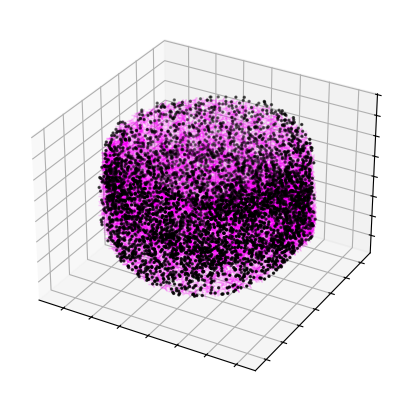

In [25]:
' LieDetect '

group, dim = 'SU(2)', 3
ambient_dim = dim_pca
FrequenciesToTest = [(3, 5)]
method_optim = 'bottom_lie_pca'
OptimalFrequencies, OptimalLieAlgebra = find_closest_algebra(group, Sigma, dim, reps_to_test=FrequenciesToTest,
                                                             method=method_optim, verbose=True)

' Generate orbit and plot '

# Generate estimated orbit
n_points_orbit = 30 ** 3
x = Y[0, :]  #initial point of X
Orbit = sample_orbit_from_algebra(group, OptimalFrequencies, OptimalLieAlgebra, nb_points=n_points_orbit, x=x)

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
print('\x1b[1;31m' + 'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff, '\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Ypca = pca.fit_transform(Y)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(Ypca[:, 0], Ypca[:, 1], Ypca[:, 2], c='black', s=2)
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:, 0], Orbitpca[:, 1], Orbitpca[:, 2], c='magenta', lw=0.5, alpha=0.1, marker="3")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
fig.savefig('figures/armadillo_orbit_' + method_data + '.png', dpi=fig.dpi, bbox_inches='tight')

## II.2. Detection of eigengaps

Count (min/max): 493.0 563.0
Count ticks (min/max): 493 563


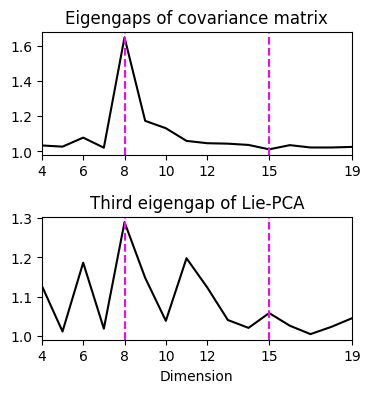

In [26]:
' Generate dataset with method mesh '

name = 'armadillo'
method_data = 'mesh'
N_img = 5000
N_voxels = 20

X = MakeDatasetFromMesh(name=name, method_data=method_data, N_img=N_img, N_voxels=N_voxels, plot=False)

' Identify eigengaps '

# Compute eigengaps in covariance matrix
S = np.mean([np.outer(X[i, :], X[i, :]) for i in range(np.shape(X)[0])], 0)
eigenvalues = np.flip(sorted(np.linalg.eig(S)[0]))
eigengaps = [eigenvalues[i] / eigenvalues[i + 1] for i in range(0, 19)]

# Compute eigengaps in LiePCA
eigengaps_LiePCA = []
for dim_pca in range(4, 20):
    Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
    n_neighbors, dim_LiePCA = 10, 3
    Sigma = get_lie_pca_operator(Y, n_neighbors, dim_LiePCA, method='PCA', verbose=False)
    vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[0:30]
    eigengaps_LiePCA.append(vals[3] / vals[2])

# Plot
fig, axs = plt.subplots(2, 1, figsize=(4, 4))
plt.subplots_adjust(wspace=0, hspace=0.5)
axs[0].plot(range(4, 20), eigengaps[3:20], c='black')
axs[1].plot(range(4, 20), eigengaps_LiePCA, c='black')
axs[0].set_title('Eigengaps of covariance matrix', fontsize=12)
axs[1].set_title('Third eigengap of Lie-PCA', fontsize=12)
axs[1].set_xlabel('Dimension', fontsize=10)
for ax in axs:
    ax.set_xticks([4, 6, 8, 10, 12, 15, 19])
    ax.axvline(8, color='magenta', ls='dashed')
    ax.axvline(15, color='magenta', ls='dashed')
    ax.set_xlim(4, 19)
fig.savefig('figures/armadillo_eigengaps_' + method_data + '.png', dpi=fig.dpi, bbox_inches='tight')

Count (min/max): 985.3209897387128 1005.0374436169658
Count ticks (min/max): 3274 4466


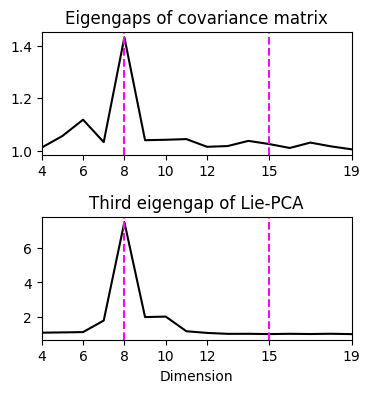

In [27]:
' Generate dataset with method voxels '

name = 'armadillo'
method_data = 'voxels'
N_img = 5000
N_voxels = 20
N_points = 1000

X = MakeDatasetFromMesh(name=name, method_data=method_data, N_img=N_img, N_points=N_points, N_voxels=N_voxels,
                        plot=False)

' Identify eigengaps '

# Compute eigengaps in covariance matrix
S = np.mean([np.outer(X[i, :], X[i, :]) for i in range(np.shape(X)[0])], 0)
eigenvalues = np.flip(sorted(np.linalg.eig(S)[0]))
eigengaps = [eigenvalues[i] / eigenvalues[i + 1] for i in range(0, 19)]

# Compute eigengaps in LiePCA
eigengaps_LiePCA = []
for dim_pca in range(4, 20):
    Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
    n_neighbors, dim_LiePCA = 10, 3
    Sigma = get_lie_pca_operator(Y, n_neighbors, dim_LiePCA, method='PCA', verbose=False)
    vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[0:30]
    eigengaps_LiePCA.append(vals[3] / vals[2])

# Plot
fig, axs = plt.subplots(2, 1, figsize=(4, 4))
plt.subplots_adjust(wspace=0, hspace=0.5)
axs[0].plot(range(4, 20), eigengaps[3:20], c='black')
axs[1].plot(range(4, 20), eigengaps_LiePCA, c='black')
axs[0].set_title('Eigengaps of covariance matrix', fontsize=12)
axs[1].set_title('Third eigengap of Lie-PCA', fontsize=12)
axs[1].set_xlabel('Dimension', fontsize=10)
for ax in axs:
    ax.set_xticks([4, 6, 8, 10, 12, 15, 19])
    ax.axvline(8, color='magenta', ls='dashed')
    ax.axvline(15, color='magenta', ls='dashed')
    ax.set_xlim(4, 19)
fig.savefig('figures/armadillo_eigengaps_' + method_data + '.png', dpi=fig.dpi, bbox_inches='tight')

Count (min/max): 848.275714264387 857.3262902227293
Count ticks (min/max): 8000 8000


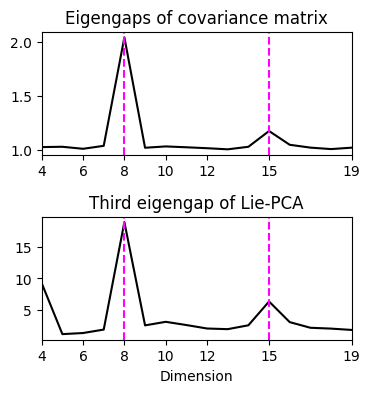

In [28]:
' Generate dataset with method kde '

name = 'armadillo'
method_data = 'kde'
N_img = 5000
N_voxels = 20
N_points = 1000
bw = .25

X = MakeDatasetFromMesh(name=name, method_data=method_data, N_img=N_img, N_voxels=N_voxels, N_points=N_points, bw=bw,
                        plot=False)

' Identify eigengaps '

# Compute eigengaps in covariance matrix
S = np.mean([np.outer(X[i, :], X[i, :]) for i in range(np.shape(X)[0])], 0)
eigenvalues = np.flip(sorted(np.linalg.eig(S)[0]))
eigengaps = [eigenvalues[i] / eigenvalues[i + 1] for i in range(0, 19)]

# Compute eigengaps in LiePCA
eigengaps_LiePCA = []
for dim_pca in range(4, 20):
    Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
    n_neighbors, dim_LiePCA = 10, 3
    Sigma = get_lie_pca_operator(Y, n_neighbors, dim_LiePCA, method='PCA', verbose=False)
    vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[0:30]
    eigengaps_LiePCA.append(vals[3] / vals[2])

# Plot
fig, axs = plt.subplots(2, 1, figsize=(4, 4))
plt.subplots_adjust(wspace=0, hspace=0.5)
axs[0].plot(range(4, 20), eigengaps[3:20], c='black')
axs[1].plot(range(4, 20), eigengaps_LiePCA, c='black')
axs[0].set_title('Eigengaps of covariance matrix', fontsize=12)
axs[1].set_title('Third eigengap of Lie-PCA', fontsize=12)
axs[1].set_xlabel('Dimension', fontsize=10)
for ax in axs:
    ax.set_xticks([4, 6, 8, 10, 12, 15, 19])
    ax.axvline(8, color='magenta', ls='dashed')
    ax.axvline(15, color='magenta', ls='dashed')
    ax.set_xlim(4, 19)
fig.savefig('figures/armadillo_eigengaps_' + method_data + '.png', dpi=fig.dpi, bbox_inches='tight')

## II.3. $\mathrm{SO}(3)$-action on armadillo in $\mathbb{R}^{15}$

Count (min/max): 848.0962529251475 857.3066562682386
Count ticks (min/max): 8000 8000
Lie PCA first eigenvalues: 1.6e-02  1.7e-02  1.8e-02  4.1e-02  Eigengap #3: 2.3e+00.


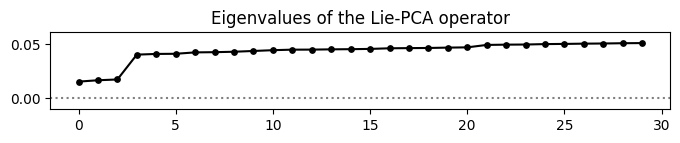

----> Optimization problem via bottom_lie_pca method for SU(2)  <----
Solve minimization problem... It 12/12. Duration 0:00:30. Remaining 0:00:00.
The optimal rep found is (3, 5, 7) with cost 2.381e-02.
    ((3, 5, 7), '-1') - cost 2.381e-02 (best cost #1/24)
    ((3, 5, 7), '+1') - cost 2.381e-02 (best cost #2/24)
    ((7, 8), '+1') - cost 3.681e-01 (best cost #3/24)
    ((7, 8), '-1') - cost 3.681e-01 (best cost #4/24)
    ((3, 12), '-1') - cost 4.065e-01 (best cost #5/24)
    ((3, 12), '+1') - cost 4.065e-01 (best cost #6/24)
    ((5, 5, 5), '+1') - cost 9.807e-01 (best cost #7/24)
    ((5, 5, 5), '-1') - cost 9.811e-01 (best cost #8/24)
    ((3, 3, 9), '+1') - cost 1.075e+00 (best cost #9/24)
    ((3, 3, 9), '-1') - cost 1.102e+00 (best cost #10/24)


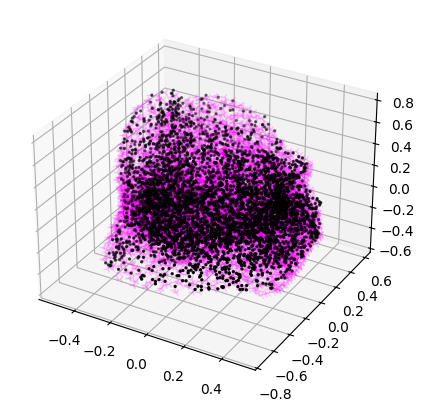

Non-symmetric Hausdorff distance from point cloud to estimated orbit: 0.3202059926540144 
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.482808595924412


In [29]:
' Generate dataset with method kde '

name = 'armadillo'
method_data = 'kde'
N_img = 5000
N_voxels = 20
N_points = 1000
bw = .25

X = MakeDatasetFromMesh(name=name, method_data=method_data, N_img=N_img, N_voxels=N_voxels, N_points=N_points, bw=bw,
                        plot=False)

' LieDetect in dimension 15 '

# Dimension reduction '
dim_pca = 15
Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
Y, _ = orthonormalize(Y)

# Lie-PCA 
n_neighbors = 50
dim_LiePCA = 3
Sigma = get_lie_pca_operator(Y, n_neighbors, dim_LiePCA, method='PCA', verbose=True)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[0:30]
fig = plt.figure(figsize=(8, 1))
ax = fig.add_subplot()
ax.plot(range(len(vals)), vals, c='black')
ax.scatter(range(len(vals)), vals, c='black', s=15)
ax.axhline(0, color='grey', linestyle='dotted')
ax.set_ylim((0 - 0.01, max(vals) + 0.01))
ax.set_title('Eigenvalues of the Lie-PCA operator')
plt.show()

# LieDetect
group, dim = 'SU(2)', 3
ambient_dim = dim_pca
method_optim = 'bottom_lie_pca'
OptimalFrequencies, OptimalLieAlgebra = find_closest_algebra(group, Sigma, dim, span_ambient_space=True,
                                                             method=method_optim, verbose=True, verbose_top_scores=True)

# Generate orbit and plot
n_points_orbit = 30 ** 3
x = Y[0, :]  # arbitrary initial point
Orbit = sample_orbit_from_algebra(group, OptimalFrequencies, OptimalLieAlgebra, nb_points=n_points_orbit, x=x)
pca = sklearn.decomposition.PCA(n_components=3)
Ypca = pca.fit_transform(Y)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(Ypca[:, 0], Ypca[:, 1], Ypca[:, 2], c='black', s=2)
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:, 0], Orbitpca[:, 1], Orbitpca[:, 2], c='magenta', lw=0.5, alpha=0.1, marker="3")
plt.show()
fig.savefig('figures/armadillo_kde_orbit_dim15.png', dpi=fig.dpi, bbox_inches='tight')

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
print('\x1b[1;31m' + 'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff, '\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

# III. Harmonic analysis

## III.1. Translated gorillas with gaussian filter

In [30]:
def feedforward(number_of_layers, neurons_per_hidden_layer, activation, inputs_shape=4):
    """
    This function creates a simple feedforward neural network
    Input: number_of_layers: number of hidden layers in the network; neurons_per_hidden_layer: width of each hidden layer, which must be the
    same for all layers; activation: activation function for each hidden layer, which must be the same; inputs_shape = 3: shape of input
    set to 3 by default
    Output model of the neural network
    """
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(inputs_shape,)))
    for i in range(number_of_layers):
        model.add(tf.keras.layers.Dense(neurons_per_hidden_layer, activation=activation))
    model.add(tf.keras.layers.Dense(1, activation='relu'))
    return model


def trains_network(model, number_of_epochs, data, target, verbose=2, plot=False):
    """
    Splits the dataset into train and validation and trains neurak network
    Input: model: the neural network to be trained; number_of_epochs: number of training epochs; data: dataset; target: dataset's labels;
    verbose = 2: verbose in training history;
    plot == False: if True, plots the training history
    """
    X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.1, random_state=42)

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mean_squared_error'])
    history = model.fit(X_train, y_train, epochs=number_of_epochs, validation_data=(X_val, y_val), batch_size=32,
                        callbacks=[callback], verbose=verbose)
    model.evaluate(data, target)

    if plot == True:
        plt.plot(history.history['val_loss'])
    return


def func_2D(beta, i, j, max_freq_fourrier, l, N_1, N_2):
    """
    Defines a regressor for a 2D regression problem
    """
    val = sum([beta[l.index(str(n) + ' ' + str(m))] * np.exp(2 * np.pi * n * 1j * i / N_1) * np.exp(
        2 * np.pi * m * 1j * j / N_2) for n in range(-max_freq_fourrier, max_freq_fourrier + 1) for m in
               range(-max_freq_fourrier, max_freq_fourrier + 1)])[0]
    return val


def regression(X, y, N_1=65, N_2=60, max_freq_fourrier=10):
    """
    Performs the regression itself using the harmonic analysis decomposition
    """
    N = X.shape[0]
    shape_transforms = (N, (2 * max_freq_fourrier + 1) ** 2)
    transform = np.ones(shape_transforms, dtype=np.complex128)
    for i in range(N):
        transform[i] = np.array(
            [np.exp(2 * np.pi * n * 1j * X[i][0] / N_1) * np.exp(2 * np.pi * m * 1j * X[i][1] / N_2) for n in
             range(-max_freq_fourrier, max_freq_fourrier + 1) for m in
             range(-max_freq_fourrier, max_freq_fourrier + 1)])
    transform_conj = transform.conjugate().T
    betas = np.linalg.pinv(transform_conj @ transform) @ transform_conj @ y.reshape(N, 1)

    return betas


def predict(X, betas, N_1=65, N_2=60, max_freq_fourrier=10):
    """
    Predict the regression results
    """
    l = [str(n) + ' ' + str(m) for n in range(-max_freq_fourrier, max_freq_fourrier + 1) for m in
         range(-max_freq_fourrier, max_freq_fourrier + 1)]

    prev = []
    for el in X:
        prev.append(func_2D(betas, el[0], el[1], max_freq_fourrier, l, N_1, N_2))
    return prev


def GaussianConvolution(shape, sigma, X):
    # Create gaussian filter of shape 'shape' from a covariance matrix 'sigma'
    gaussian_filter = np.ones(shape)
    mean = np.array([shape[0] / 2, shape[1] / 2])
    sigma_inv = np.linalg.inv(sigma)
    for i in range(shape[0]):
        for j in range(shape[1]):
            gaussian_filter[i, j, :] = np.exp(
                -1 / 2 * (np.array([i, j]) - mean).T @ sigma_inv @ (np.array([i, j]) - mean))

    # Convolve the images 
    # (translate the images so that the head of the gorilla is in the center, for better looking image)
    X_conv = np.array([[X[(i + int(X.shape[0] / 2)) % X.shape[0], (j + int(X.shape[1] / 2)) % X.shape[1], :].reshape(
        np.shape(img)) * gaussian_filter for i in range(np.shape(X)[0])] for j in range(np.shape(X)[1])])

    # Define the regression function and normalize
    F = np.array([[np.sum(X_conv[i, j, :, :, :], (0, 1, 2)) for i in range(np.shape(X_conv)[0])] for j in
                  range(np.shape(X_conv)[1])])
    F -= np.min(F)
    F /= np.max(F)

    return gaussian_filter, X_conv, F


def GenerateOrbitTorusWithCoordinates(LieAlgebra, n_points, x):
    # Generate first circle
    coefficient = 1 / 2
    T = np.linspace(0, 2 * 2 * np.pi, n_points)
    Coordinates = np.array([t for t in T])
    Orbit = np.array([scipy.linalg.expm(t * LieAlgebra[0] * coefficient) @ x for t in T])

    # Apply next transformations
    for i in range(1, len(LieAlgebra)):
        coefficient = 1 / 2
        Coordinates = [(t, y) for y in Coordinates for t in T]
        Orbit = [[scipy.linalg.expm(t * LieAlgebra[i] * coefficient) @ y for t in T] for y in Orbit]
        Orbit = np.concatenate(Orbit)

    return Orbit, Coordinates

The RGB image has shape (130, 120, 3)
The point cloud (collection of translated images) has shape (65, 60, 46800)
Shape of train and test sets: (3510, 50) (390, 50)


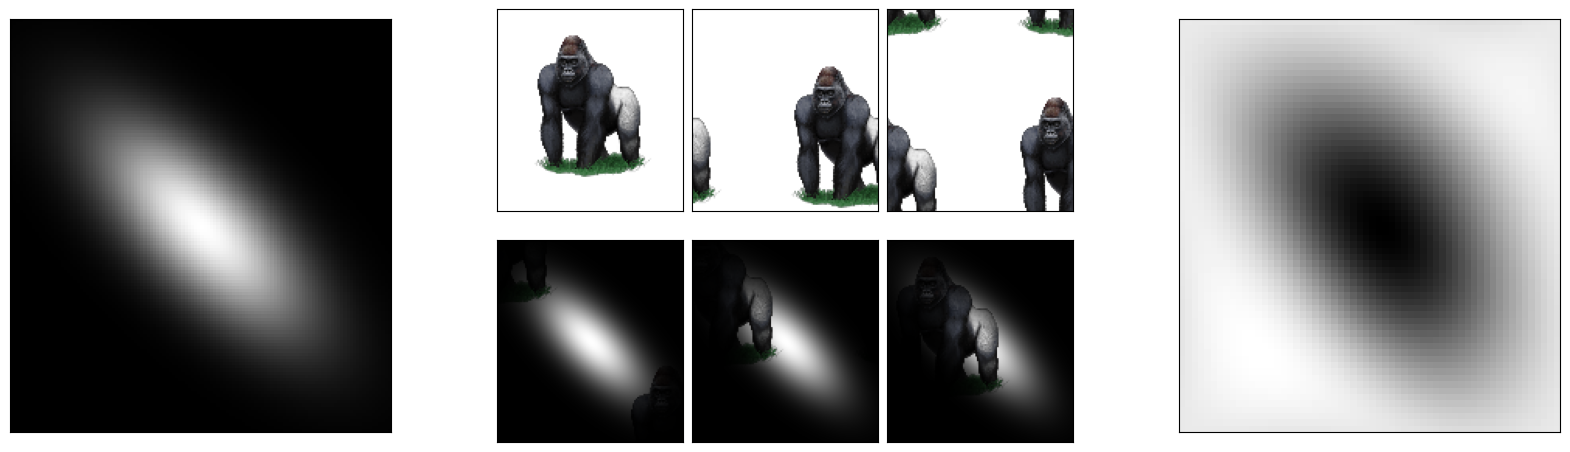

In [31]:
' Generate dataset - translated gorillas '

# Open image file and resize
img = plt.imread('data/gorilla.png')
img = img[::7, ::7, 0:3]  # select 1 every 7 pixels
img = img[7:137, 9:130]  # center image
nx, ny, _ = np.shape(img)
print('The RGB image has shape', np.shape(img))

# Translate image and flatten
Images = np.array([[np.roll(np.roll(img, i, 0), j, 1).flatten() for j in range(0, ny, 2)] for i in range(0, nx, 2)])
print('The point cloud (collection of translated images) has shape', np.shape(Images))

' Create regression target '

# Create dataset
sigma = 500 * np.array([[1, 0.7], [0.7, 1]])
# sigma = 500*np.array([[1,0.6],[0.6,1]])
gaussian_filter, Images_conv, y = GaussianConvolution(shape=np.shape(img), sigma=sigma, X=Images)

# Dimension reduction
dim_pca = 50
X = Images.reshape(Images.shape[0] * Images.shape[1], Images.shape[2])
X = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)

# Splits data into training and test
y = y.reshape(-1)
# y = np.array([np.sin(j*np.pi/60)+np.sin(i*np.pi/65) for i in range(65) for j in range(60)]) # another task: geodesic distance to origin
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
print('Shape of train and test sets:', np.shape(X_train), np.shape(X_test))

# Plot
fig = plt.figure(figsize=(20, 6))
fig.tight_layout()
gs = matplotlib.gridspec.GridSpec(2, 16)
gs.update(wspace=0.1, hspace=0.0)
ax1 = plt.subplot(gs[0:2, 0:4])
ax2 = plt.subplot(gs[0:2, 12:16])
axs1 = [plt.subplot(gs[0, 5:7]), plt.subplot(gs[1, 5:7])]
axs2 = [plt.subplot(gs[0, 7:9]), plt.subplot(gs[1, 7:9])]
axs3 = [plt.subplot(gs[0, 9:11]), plt.subplot(gs[1, 9:11])]
for ax in [ax1, ax2] + axs1 + axs2 + axs3:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
ax1.imshow(gaussian_filter, cmap='gray')
ax2.imshow(y.reshape(65, 60), cmap='gray')
axs1[0].imshow(Images[0, 0].reshape(np.shape(img)))
axs1[1].imshow(Images_conv[0, 0].reshape(np.shape(img)))
axs1[0].imshow(Images[0, 0].reshape(np.shape(img)))
axs1[1].imshow(Images_conv[0, 0].reshape(np.shape(img)))
axs2[0].imshow(Images[10, 20].reshape(np.shape(img)))
axs2[1].imshow(Images_conv[10, 20].reshape(np.shape(img)))
axs3[0].imshow(Images[20, 30].reshape(np.shape(img)))
axs3[1].imshow(Images_conv[20, 30].reshape(np.shape(img)))
fig.savefig('figures/harmonic_analysis_gaussianfilter_dataset.png', dpi=fig.dpi, bbox_inches='tight')

Lie PCA first eigenvalues: 1.3e-04  2.2e-04  1.2e-01  1.2e-01  Eigengap #2: 5.7e+02.
----> Optimization problem via abelian method for torus  <----
The optimal rep found is ((-1, 0), (0, -1)) with cost 1.570e-16.
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 0.042154677574979864 
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.08893325127571079


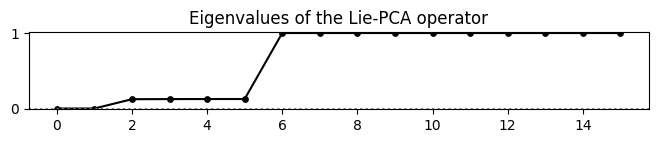

In [32]:
' LieDetect on train set '

# Orthonormalization
pca = sklearn.decomposition.PCA(n_components=4).fit(X_train)
X_train_orth, Cov = orthonormalize(pca.transform(X_train))

# Lie-PCA
n_neighbors = 8
dim_LiePCA = 2
Sigma = get_lie_pca_operator(X_train_orth, n_neighbors, dim_LiePCA, method='PCA', verbose=True)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[0:30]
fig = plt.figure(figsize=(8, 1))
ax = fig.add_subplot()
ax.plot(range(len(vals)), vals, c='black')
ax.scatter(range(len(vals)), vals, c='black', s=15)
ax.axhline(0, color='grey', linestyle='dotted')
ax.set_ylim((0 - 0.01, max(vals) + 0.01))
ax.set_title('Eigenvalues of the Lie-PCA operator')

# LieDetect
group, dim = 'torus', 2
ambient_dim = 4
method_optim, FrequenciesToTest = 'abelian', [((1, 0), (0, 1))]
OptimalFrequencies, OptimalLieAlgebra = find_closest_algebra(group, Sigma, dim, ambient_dim,
                                                             reps_to_test=FrequenciesToTest, method=method_optim,
                                                             verbose=True)

# Generate estimated orbit
n_points_orbit = 300
x = X_train_orth[0, :]  #initial point
Orbit, CoordinatesOrbit = GenerateOrbitTorusWithCoordinates(OptimalLieAlgebra, n_points=n_points_orbit, x=x)

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(X_train_orth, Orbit)[0]
print('\x1b[1;31m' + 'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff, '\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X_train_orth)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

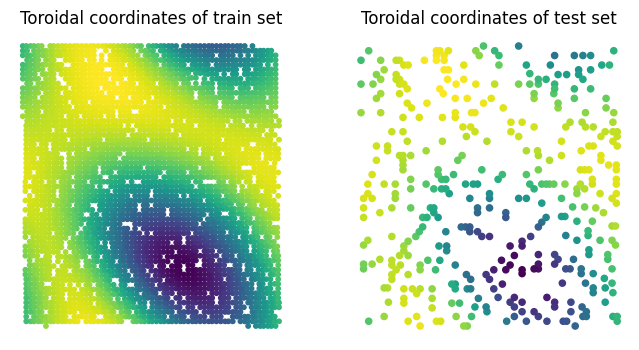

In [33]:
' Compute toroidal coordinates '

# Get toroidal coordinates of whole set
ToroidalCoordinatesAll = []
for i in range(np.shape(X)[0]):
    # ind_argmin = np.argmin(np.linalg.norm(Cov@X[i,:]-Orbit, axis=1))
    ind_argmin = np.argmin(np.linalg.norm(Cov @ (pca.transform(X[i, :].reshape(1, -1)).T).reshape(-1) - Orbit, axis=1))
    ToroidalCoordinatesAll.append(CoordinatesOrbit[ind_argmin])
ToroidalCoordinatesAll = np.array(ToroidalCoordinatesAll)

# Get toroidal coordinates of train set
ToroidalCoordinatesTrain = []
for i in range(np.shape(X_train)[0]):
    # ind_argmin = np.argmin(np.linalg.norm(Cov@X_train[i,:]-Orbit, axis=1))
    ind_argmin = np.argmin(
        np.linalg.norm(Cov @ (pca.transform(X_train[i, :].reshape(1, -1)).T).reshape(-1) - Orbit, axis=1))
    ToroidalCoordinatesTrain.append(CoordinatesOrbit[ind_argmin])
ToroidalCoordinatesTrain = np.array(ToroidalCoordinatesTrain)

# Get toroidal coordinates of test set
ToroidalCoordinatesTest = []
for i in range(np.shape(X_test)[0]):
    # ind_argmin = np.argmin(np.linalg.norm(Cov@X_test[i,:]-Orbit, axis=1))
    ind_argmin = np.argmin(
        np.linalg.norm(Cov @ (pca.transform(X_test[i, :].reshape(1, -1)).T).reshape(-1) - Orbit, axis=1))
    ToroidalCoordinatesTest.append(CoordinatesOrbit[ind_argmin])
ToroidalCoordinatesTest = np.array(ToroidalCoordinatesTest)

# Plot
fig = plt.figure(figsize=(4 * 2, 4))
ax = fig.add_subplot(121)
ax.set_title('Toroidal coordinates of train set', )
ax.axis('off')
ax.scatter(ToroidalCoordinatesTrain[:, 0], ToroidalCoordinatesTrain[:, 1], c=y_train, s=10)
ax = fig.add_subplot(122)
ax.set_title('Toroidal coordinates of test set')
ax.axis('off')
ax.scatter(ToroidalCoordinatesTest[:, 0], ToroidalCoordinatesTest[:, 1], c=y_test, s=20)
fig.savefig('figures/toroidal_coordinates.png', dpi=fig.dpi, bbox_inches='tight')

Mean squared error (test set):  6.0038936888887987e-05 
Mean squared error (all set):   4.662144203336799e-05


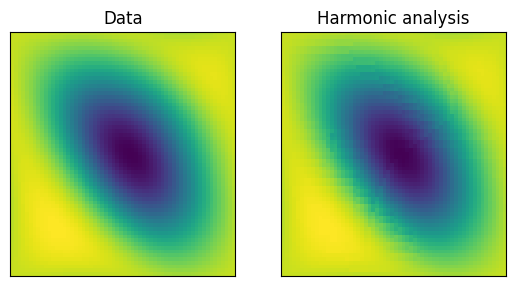

In [34]:
Scores = []

' Regression with harmonic analysis '

# Get indices of toroidal coordinates
N_1, N_2 = 65, 60
X_indices_all = np.array([ToroidalCoordinatesAll[:, 0] / ToroidalCoordinatesAll.max() * N_1,
                          ToroidalCoordinatesAll[:, 1] / ToroidalCoordinatesAll.max() * N_2], dtype=int).T
X_indices_train = np.array([ToroidalCoordinatesTrain[:, 0] / ToroidalCoordinatesTrain.max() * N_1,
                            ToroidalCoordinatesTrain[:, 1] / ToroidalCoordinatesTrain.max() * N_2], dtype=int).T
X_indices_test = np.array([ToroidalCoordinatesTest[:, 0] / ToroidalCoordinatesTest.max() * N_1,
                           ToroidalCoordinatesTest[:, 1] / ToroidalCoordinatesTest.max() * N_2], dtype=int).T

# Train
beta = regression(X_indices_train, y_train, N_1=N_1, N_2=N_2, max_freq_fourrier=10)  #estimate coefficients betas

# Predict
predictions_test = np.real(predict(X_indices_test, beta))  # Predictions on test set
predictions_all = np.real(predict(X_indices_all, beta))
mse = sum((predictions_test - y_test) ** 2) / len(y_test)
print('\x1b[1;31m' + 'Mean squared error (test set): ', mse, '\x1b[0m')
Scores.append(('Toroidal coordinates', mse, predictions_all.copy()))

mse = sum((predictions_all - y) ** 2) / len(y)
print('Mean squared error (all set):  ', mse)

# Plot
fig, axs = plt.subplots(1, 2)
for ax in axs:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
axs[0].imshow(y.reshape(65, 60))
axs[0].set_title('Data')
axs[1].imshow(predictions_all.reshape(65, 60))
axs[1].set_title('Harmonic analysis');

Mean squared error (test set):  3.8973644913604014e-05 
Mean squared error (all set):   1.1189179643443236e-05


Text(0.5, 1.0, 'Random forest')

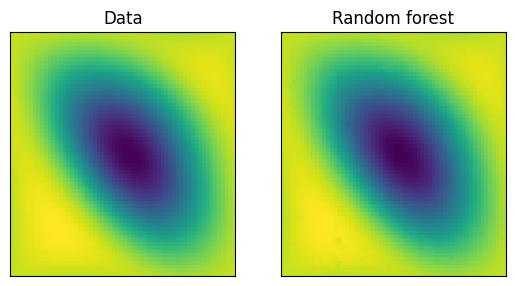

In [35]:
' Regression with random forest '

# Train
regr = RandomForestRegressor(random_state=0).fit(X_train, y_train)

# Predict
predictions_test = regr.predict(X_test)  # Predictions on test set
predictions_all = regr.predict(X)  # Predictions on whole dataset
mse = sum((predictions_test - y_test) ** 2) / len(y_test)
print('\x1b[1;31m' + 'Mean squared error (test set): ', mse, '\x1b[0m')
Scores.append(('Random forest', mse, predictions_all.copy()))

mse = sum((predictions_all - y) ** 2) / len(X)
print('Mean squared error (all set):  ', mse)

# Plot
fig, axs = plt.subplots(1, 2)
for ax in axs:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
axs[0].imshow(y.reshape(65, 60))
axs[0].set_title('Data')
axs[1].imshow(predictions_all.reshape(65, 60))
axs[1].set_title('Random forest')

Mean squared error (test set):  8.700745727381719e-05 
Mean squared error (all set):   8.87958438952338e-05


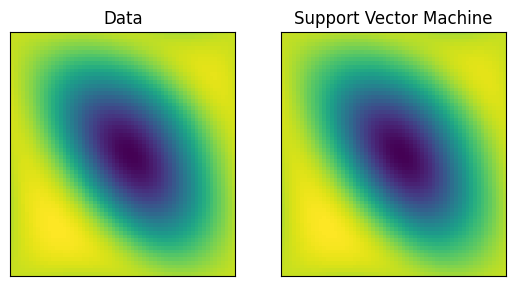

In [36]:
' Regression with SVM '

# Train
param_grid = {"SVR__C": [0.1, 1, 10, 100], "SVR__epsilon": [0.01, 0.1, 0.5, 1]}
regr = Pipeline(steps=[('scaler', StandardScaler()), ('SVR', SVR())])
grid = GridSearchCV(regr, param_grid, refit=True, verbose=0)
grid.fit(X_train, y_train)

# Predict
predictions_test = grid.predict(X_test)  # Predictions on test set
predictions_all = grid.predict(X)  # Predictions on whole dataset
mse = sum((predictions_test - y_test) ** 2) / len(y_test)
print('\x1b[1;31m' + 'Mean squared error (test set): ', mse, '\x1b[0m')
Scores.append(('Support Vector Machine', mse, predictions_all.copy()))

mse = sum((predictions_all - y) ** 2) / len(y)
print('Mean squared error (all set):  ', mse)

# Plot
fig, axs = plt.subplots(1, 2)
for ax in axs:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
axs[0].imshow(y.reshape(65, 60))
axs[0].set_title('Data')
axs[1].imshow(predictions_all.reshape(65, 60))
axs[1].set_title('Support Vector Machine');

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step
Mean squared error (test set):  0.00010214885430703887 
Mean squared error (all set):   9.524361932290663e-05


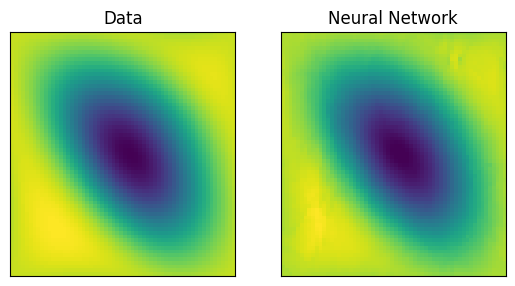

In [37]:
' Regression with MLP '

# Train 
model = feedforward(2, 10, 'relu', inputs_shape=50)
trains_network(model, 300, X_train, y_train, plot=False)
IPython.display.clear_output()

# Predict
predictions_test = model.predict(X_test).reshape(-1)  # Predictions on test set
predictions_all = model.predict(X).reshape(-1)  # Predictions on whole dataset
mse = sum((predictions_test - y_test) ** 2) / len(y_test)
print('\x1b[1;31m' + 'Mean squared error (test set): ', mse, '\x1b[0m')
Scores.append(('Neural Network', mse, predictions_all.copy()))

mse = sum((predictions_all - y) ** 2) / len(y)
print('Mean squared error (all set):  ', mse)

# Plot
fig, axs = plt.subplots(1, 2)
for ax in axs:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
axs[0].imshow(y.reshape(65, 60))
axs[0].set_title('Data')
axs[1].imshow(predictions_all.reshape(65, 60))
axs[1].set_title('Neural Network');

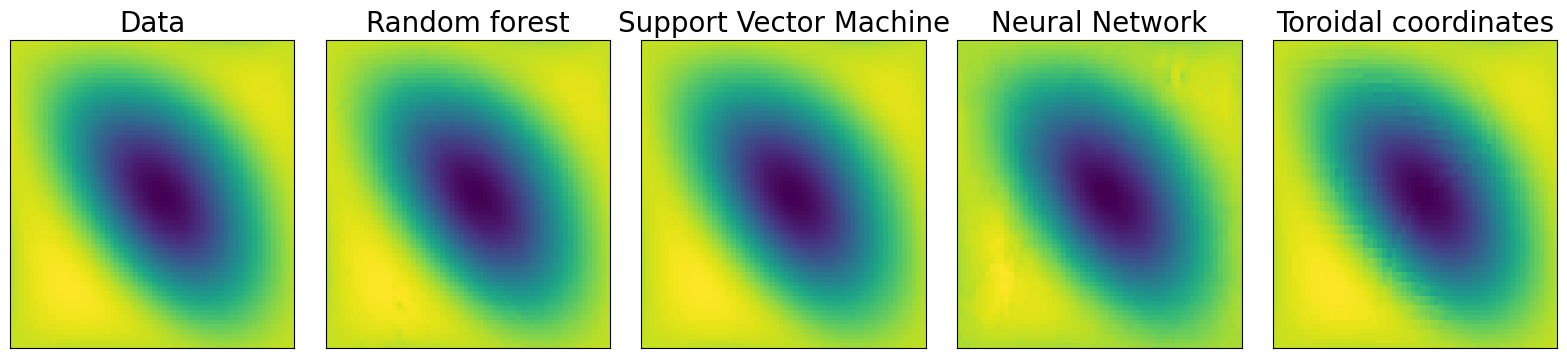

| Model | MSE on test data |
 | --- | --- | 
Random forest|0.000038974|
Support Vector Machine|0.000087007|
Neural Network|0.000102149|
Toroidal coordinates|0.000060039|

\begin{longtable}{||c|c||}\hline Model&MSE on test data\\*\hlineRandom forest&0.000038974\\Support Vector Machine&0.000087007\\Neural Network&0.000102149\\Toroidal coordinates&0.000060039\\*\hline\end{longtable}


In [38]:
' Show results '

Scores = [Scores[i] for i in [1, 2, 3, 0]]

# Plot results
fig, axs = plt.subplots(1, 5, figsize=(4 * 5, 4))
plt.subplots_adjust(wspace=0.1, hspace=0)
for ax in axs:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
axs[0].imshow(y.reshape(65, 60))
axs[0].set_title('Data', fontsize=20)
for i, score in enumerate(Scores):
    axs[i + 1].imshow(score[2].reshape(65, 60))
    axs[i + 1].set_title(score[0], fontsize=20)
plt.show()
fig.savefig('figures/harmonic_analysis_gaussianfilter_results.png', dpi=fig.dpi, bbox_inches='tight')

# Print scores in markdown and latex
str_markdown = '| Model | MSE on test data |\n | --- | --- | \n' + '\n'.join(
    [str(score[0]) + '|' + '{:.9f}'.format(score[1]) + '|' for score in Scores])
IPython.display.display_markdown(str_markdown, raw=True)
str_latex = '\\begin{longtable}{||c|c||}\\hline Model&MSE on test data\\\\*\\hline' + '\\\\'.join(
    [str(score[0]) + '&' + '{:.9f}'.format(score[1]) for score in Scores]) + '\\\\*\\hline\\end{longtable}'
print(str_latex)

## III.2. Learning rotation matrices from armadillo, voxels embedding

In [39]:
def GenerateOrbitSU2WithCoordinates(LieAlgebra, frequencies, n_points, x):
    # Define coefficient and sanity check
    coefficient = get_periods("SU(2)", frequencies, LieAlgebra)[0]
    if any([np.linalg.norm(scipy.linalg.expm(coefficient * A) - np.eye(np.shape(A)[0])) > 1e-5 for A in LieAlgebra]):
        print('Error! Incorrect coefficient', coefficient)
        for A in LieAlgebra: print(np.linalg.norm(scipy.linalg.expm(coefficient * A) - np.eye(np.shape(A)[0])))

    # Generate first circle
    T = np.linspace(0, coefficient, n_points)
    Coordinates = np.array([t for t in T])
    Orbit = np.array([scipy.linalg.expm(t * LieAlgebra[0]) @ x for t in T])

    # Apply next transformations
    for i in range(1, 3):
        Coordinates = [(t, y) for y in Coordinates for t in T]
        Orbit = np.concatenate([[scipy.linalg.expm(t * LieAlgebra[i]) @ y for t in T] for y in Orbit])

    Coordinates = [(t[1][1], t[1][0], t[0]) for t in Coordinates]
    return Orbit, Coordinates, coefficient

Count (min/max): 978.1968079533137 1001.6992305526069
Count ticks (min/max): 3322 4445
Lie PCA first eigenvalues: 5.2e-03  9.1e-03  9.5e-03  4.3e-02  Eigengap #3: 4.5e+00.


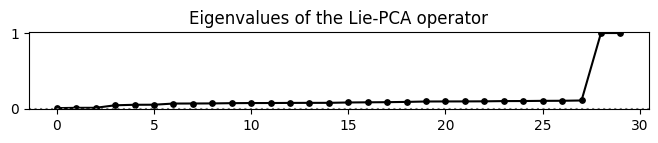

----> Optimization problem via bottom_lie_pca method for SU(2)  <----
Solve minimization problem... It 1/1. Duration 0:00:00. Remaining 0:00:00.
The optimal rep found is (3, 5) with cost 4.239e-03.
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 0.3953019964514771 
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.48910520659158163


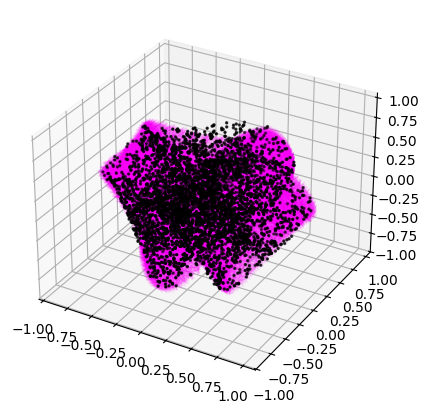

In [40]:
' LieDetect on armadillo in R^8 '

# Generate point cloud
name = 'armadillo'
method_data = 'voxels'
N_img = 5000
N_voxels = 20
N_points = 1000
X, Rotations, Directions, Angles = MakeDatasetFromMesh(name=name, method_data=method_data, N_img=N_img,
                                                       N_points=N_points, N_voxels=N_voxels, plot=False,
                                                       return_Rotations=True)

# Dimension reduction
dim_pca = 8
Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
Y -= np.mean(Y, 0)
Y = np.array([p / np.linalg.norm(p) for p in Y])
Y, _ = orthonormalize(Y)

# Lie-PCA
n_neighbors = 10
dim_LiePCA = 3
Sigma = get_lie_pca_operator(Y, n_neighbors, dim_LiePCA, method='PCA', verbose=True)
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[0:30]
fig = plt.figure(figsize=(8, 1))
ax = fig.add_subplot()
ax.plot(range(len(vals)), vals, c='black')
ax.scatter(range(len(vals)), vals, c='black', s=15)
ax.axhline(0, color='grey', linestyle='dotted')
ax.set_ylim((0 - 0.01, max(vals) + 0.01))
ax.set_title('Eigenvalues of the Lie-PCA operator')
plt.show()

# LieDetect
group, dim = 'SU(2)', 3
ambient_dim = dim_pca
FrequenciesToTest = [(3, 5)]
method_optim = 'bottom_lie_pca'
OptimalFrequencies, OptimalLieAlgebra = find_closest_algebra(group, Sigma, dim, reps_to_test=FrequenciesToTest,
                                                             method=method_optim, verbose=True)

# Generate estimated orbit
n_points_orbit = 40
x = Y[0, :]
Orbit, CoordinatesOrbit, coefficient_rep = GenerateOrbitSU2WithCoordinates(OptimalLieAlgebra, OptimalFrequencies,
                                                                           n_points=n_points_orbit, x=x)

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
print('\x1b[1;31m' + 'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff, '\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Ypca = pca.fit_transform(Y)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(Ypca[:, 0], Ypca[:, 1], Ypca[:, 2], c='black', s=2)
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:, 0], Orbitpca[:, 1], Orbitpca[:, 2], c='magenta', lw=0.4, alpha=0.1, marker="3")
plt.show()

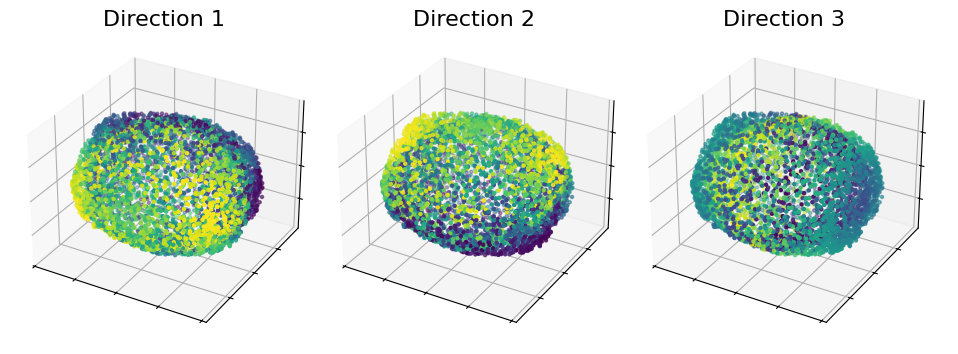

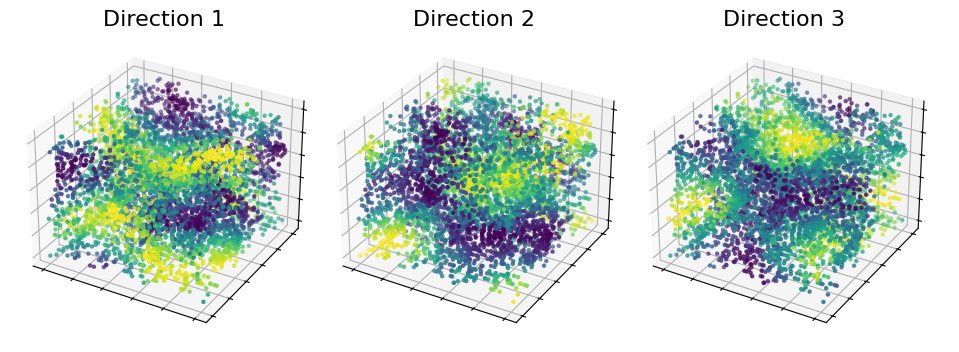

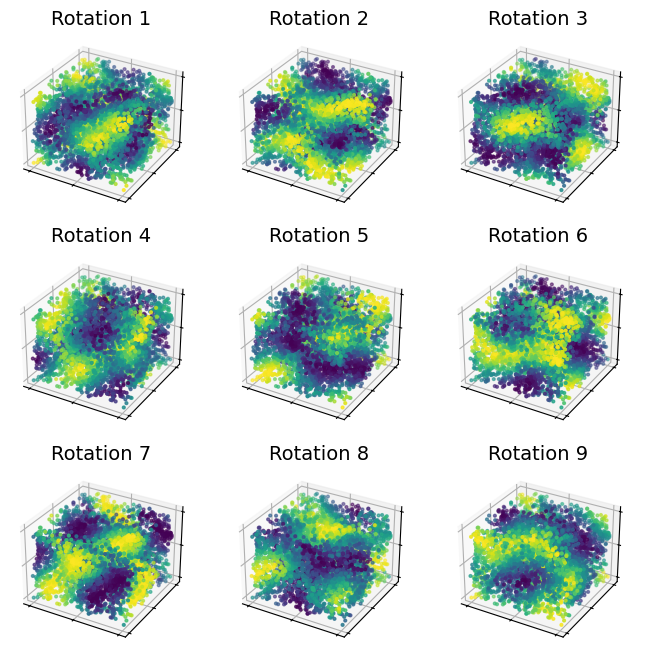

In [41]:
' Plot objectives '

# Plot objectives
fontsize = 16
fig = plt.figure(figsize=(3 * 4, 4))
plt.subplots_adjust(wspace=0, hspace=0.0)
Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
    ax.scatter(Xpca[:, 0], Xpca[:, 1], Xpca[:, 2], c=Directions[:, i], s=5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_title('Direction ' + repr(i + 1), fontsize=fontsize)
fig.savefig('figures/armadillo_coordinates_objective.png', dpi=fig.dpi, bbox_inches='tight')

# Define SU(2) coordinates on the point cloud
Coordinates = []
for i in range(np.shape(X)[0]):
    ind_argmin = np.argmin(np.linalg.norm(Y[i, :] - Orbit, axis=1))
    Coordinates.append(CoordinatesOrbit[ind_argmin] / coefficient_rep)
Coordinates = np.array(Coordinates)

# Plot SU(2) coordinates - Directions and Angles
fontsize = 16
fig = plt.figure(figsize=(3 * 4, 4))
plt.subplots_adjust(wspace=0, hspace=0.0)
for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
    ax.scatter(Coordinates[:, 0], Coordinates[:, 1], Coordinates[:, 2], c=Directions[:, i], s=5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_title('Direction ' + repr(i + 1), fontsize=fontsize)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
fig.savefig('figures/armadillo_coordinates_directionsincoordinates.png', dpi=fig.dpi, bbox_inches='tight')

# Plot SU(2) coordinates - Rotations
fontsize = 14
fig = plt.figure(figsize=(4 * 2, 4 * 2))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for i in range(3 * 3):
    ax = fig.add_subplot(3, 3, i + 1, projection='3d')
    R = Rotations[:, i]
    R -= R.min()
    R /= R.max()
    ax.scatter(Coordinates[:, 0], Coordinates[:, 1], Coordinates[:, 2], c=R, s=4)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_title('Rotation ' + repr(i + 1), fontsize=fontsize)
fig.savefig('figures/armadillo_coordinates_rotationsincoordinates.png', dpi=fig.dpi, bbox_inches='tight');

In [42]:
' Compute scores '

Scores = []
param_grid = {'SVR__C': [1, 10, 100], 'SVR__epsilon': [0.1, 1]}

# Estimate from whole embedding
for dim_pca in range(3, 10 + 1):
    name = 'SVM in dimension ' + repr(dim_pca)
    print(name)
    input_data = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
    score = []
    for output_data in [Directions[:, 0], Directions[:, 1], Directions[:, 2], Angles]:
        # Train
        X_train, X_test, y_train, y_test = train_test_split(input_data, list(output_data), test_size=0.1,
                                                            random_state=42)
        regr = Pipeline(steps=[('scaler', StandardScaler()), ('SVR', SVR())])
        grid = GridSearchCV(regr, param_grid, refit=True, verbose=0)
        grid.fit(X_train, y_train)

        # Predict
        predictions_test = grid.predict(X_test)  # Predictions on test set
        mse = np.mean((predictions_test - y_test) ** 2)
        score.append(mse)
        print('\x1b[1;31m' + 'Mean squared error (test set): ', mse, '\x1b[0m')
        predictions_train = grid.predict(X_train)  # Predictions on train set
        mse = np.mean((predictions_train - y_train) ** 2)
        print('Mean squared error (train set): ', mse)
    Scores.append([name] + score)

# Estimate from SU(2) coordinates 
name = 'SVM on coordinates'
print(name)
input_data = Coordinates
score = []
for output_data in [Directions[:, 0], Directions[:, 1], Directions[:, 2], Angles]:
    # Train
    X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.1, random_state=42)
    regr = Pipeline(steps=[('scaler', StandardScaler()), ('SVR', SVR())])
    grid = GridSearchCV(regr, param_grid, refit=True, verbose=0)
    grid.fit(X_train, y_train)

    # Predict
    predictions_test = grid.predict(X_test)  # Predictions on test set
    mse = np.mean((predictions_test - y_test) ** 2)
    score.append(mse)
    print('\x1b[1;31m' + 'Mean squared error (test set): ', mse, '\x1b[0m')
    predictions_train = grid.predict(X_train)  # Predictions on train set
    mse = np.mean((predictions_train - y_train) ** 2)
    print('Mean squared error (train set): ', mse)
Scores.append([name] + score)

IPython.display.clear_output()

# Print scores in markdown and latex 
Scores = [[score[0], sum(score[1:4]), score[4]] for score in Scores]
str_markdown = '| Model | MSE direction | MSE angle | \n | --- | --- | --- | \n' + '\n'.join(
    [str(score[0]) + '|' + '{:.4f}'.format(score[1]) + '|' + '{:.4f}'.format(score[2]) + '|' for score in Scores])
IPython.display.display_markdown(str_markdown, raw=True)

# Print scores only direction
str_markdown = '| Model | MSE on test data | \n | --- | ---  \n' + '\n'.join(
    [str(score[0]) + '|' + '{:.4f}'.format(score[1]) + '|' for score in Scores])
IPython.display.display_markdown(str_markdown, raw=True)
str_latex = '\\begin{longtable}{||c|c||}\\hline Model&MSE on test data\\\\*\\hline ' + ' \\\\ '.join(
    [str(score[0]) + '&' + '{:.4f}'.format(score[1]) for score in Scores]) + '\\\\*\\hline\\end{longtable}'
print(str_latex)

| Model | MSE direction | MSE angle | 
 | --- | --- | --- | 
SVM in dimension 3|0.4314|0.1222|
SVM in dimension 4|0.2967|0.0558|
SVM in dimension 5|0.1508|0.0220|
SVM in dimension 6|0.0712|0.0114|
SVM in dimension 7|0.0257|0.0041|
SVM in dimension 8|0.0099|0.0036|
SVM in dimension 9|0.0097|0.0035|
SVM in dimension 10|0.0109|0.0038|
SVM on coordinates|0.0075|0.0031|

| Model | MSE on test data | 
 | --- | ---  
SVM in dimension 3|0.4314|
SVM in dimension 4|0.2967|
SVM in dimension 5|0.1508|
SVM in dimension 6|0.0712|
SVM in dimension 7|0.0257|
SVM in dimension 8|0.0099|
SVM in dimension 9|0.0097|
SVM in dimension 10|0.0109|
SVM on coordinates|0.0075|

\begin{longtable}{||c|c||}\hline Model&MSE on test data\\*\hline SVM in dimension 3&0.4314 \\ SVM in dimension 4&0.2967 \\ SVM in dimension 5&0.1508 \\ SVM in dimension 6&0.0712 \\ SVM in dimension 7&0.0257 \\ SVM in dimension 8&0.0099 \\ SVM in dimension 9&0.0097 \\ SVM in dimension 10&0.0109 \\ SVM on coordinates&0.0075\\*\hline\end{longtable}


## III.3. Learning rotation matrices from armadillo, KDE embedding

Count (min/max): 849.1935208839461 857.3060266445355
Count ticks (min/max): 8000 8000
Lie PCA first eigenvalues: 3.4e-03  3.6e-03  3.8e-03  5.9e-02  Eigengap #3: 1.6e+01.


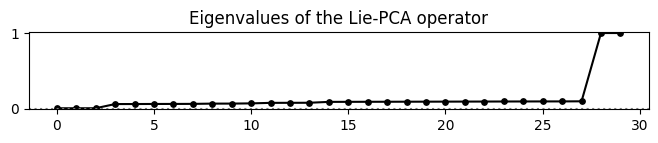

----> Optimization problem via bottom_lie_pca method for SU(2)  <----
Solve minimization problem... It 1/1. Duration 0:00:00. Remaining 0:00:00.
The optimal rep found is (3, 5) with cost 3.697e-04.
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 0.18374242583676215 
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.37288843097842994


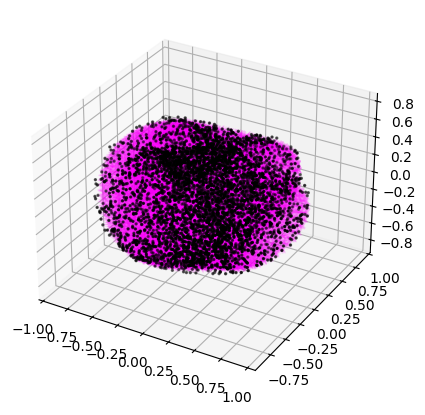

In [43]:
' LieDetect on armadillo in R^8 '

# Generate point cloud
name = 'armadillo'
method_data = 'kde'
N_img = 5000
N_voxels = 20
N_points = 1000
bw = .25
X, Rotations, Directions, Angles = MakeDatasetFromMesh(name=name, method_data=method_data, N_img=N_img,
                                                       N_voxels=N_voxels, N_points=N_points, bw=bw, plot=False,
                                                       return_Rotations=True)

# Dimension reduction
dim_pca = 8
Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
Y -= np.mean(Y, 0)
Y, _ = orthonormalize(Y)
Y = np.array([p / np.linalg.norm(p) for p in Y])

# Lie-PCA
n_neighbors = 10
dim_LiePCA = 3
Sigma = get_lie_pca_operator(Y, n_neighbors, dim_LiePCA, method='PCA', verbose=True)
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[0:30]
fig = plt.figure(figsize=(8, 1))
ax = fig.add_subplot()
ax.plot(range(len(vals)), vals, c='black')
ax.scatter(range(len(vals)), vals, c='black', s=15)
ax.axhline(0, color='grey', linestyle='dotted')
ax.set_ylim((0 - 0.01, max(vals) + 0.01))
ax.set_title('Eigenvalues of the Lie-PCA operator')
plt.show()

# LieDetect
group, dim = 'SU(2)', 3
ambient_dim = dim_pca
FrequenciesToTest = [(3, 5)]
method_optim = 'bottom_lie_pca'
OptimalFrequencies, OptimalLieAlgebra = find_closest_algebra(group, Sigma, dim, reps_to_test=FrequenciesToTest,
                                                             method=method_optim, verbose=True)

# Generate estimated orbit
n_points_orbit = 40
x = Y[0, :]  #initial point of X
Orbit, CoordinatesOrbit, coefficient_rep = GenerateOrbitSU2WithCoordinates(OptimalLieAlgebra, OptimalFrequencies,
                                                                           n_points=n_points_orbit, x=x)

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
print('\x1b[1;31m' + 'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff, '\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Ypca = pca.fit_transform(Y)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(Ypca[:, 0], Ypca[:, 1], Ypca[:, 2], c='black', s=2)
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:, 0], Orbitpca[:, 1], Orbitpca[:, 2], c='magenta', lw=0.4, alpha=0.1, marker="3");

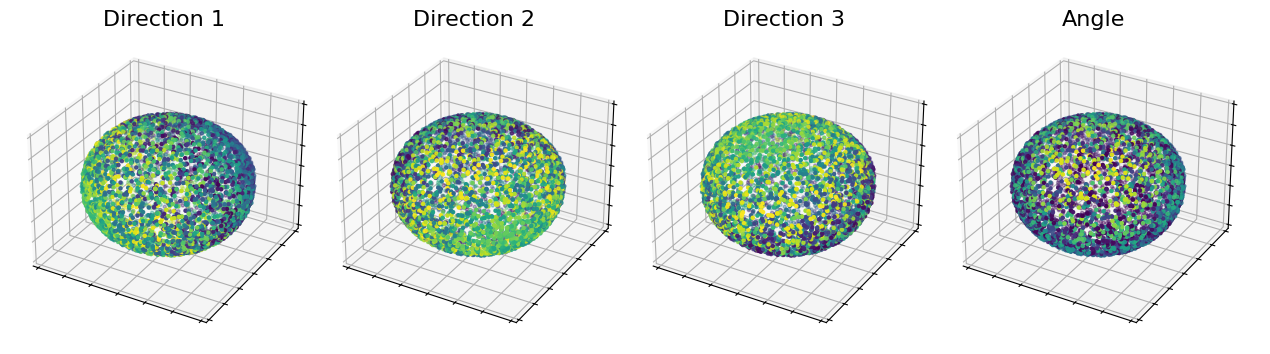

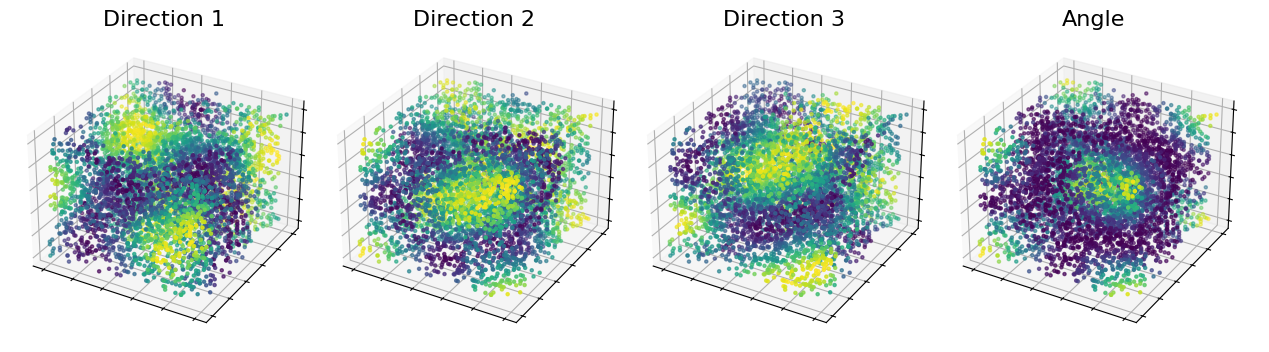

In [44]:
' Plot objectives '

# Plot objectives
fontsize = 16
fig = plt.figure(figsize=(4 * 4, 4))
plt.subplots_adjust(wspace=0, hspace=0.0)
Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
for i in range(3):
    ax = fig.add_subplot(1, 4, i + 1, projection='3d')
    ax.scatter(Xpca[:, 0], Xpca[:, 1], Xpca[:, 2], c=Directions[:, i], s=5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_title('Direction ' + repr(i + 1), fontsize=fontsize)
ax = fig.add_subplot(144, projection='3d')
ax.scatter(Xpca[:, 0], Xpca[:, 1], Xpca[:, 2], c=Angles, s=5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_title('Angle', fontsize=fontsize)

# Define SU(2) coordinates on the point cloud
Coordinates = []
for i in range(np.shape(X)[0]):
    ind_argmin = np.argmin(np.linalg.norm(Y[i, :] - Orbit, axis=1))
    Coordinates.append(CoordinatesOrbit[ind_argmin] / coefficient_rep)
Coordinates = np.array(Coordinates)

# Plot SU(2) coordinates - Directions and Angles
fontsize = 16
fig = plt.figure(figsize=(4 * 4, 4))
plt.subplots_adjust(wspace=0, hspace=0.0)
for i in range(3):
    ax = fig.add_subplot(1, 4, i + 1, projection='3d')
    ax.scatter(Coordinates[:, 0], Coordinates[:, 1], Coordinates[:, 2], c=Directions[:, i], s=5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_title('Direction ' + repr(i + 1), fontsize=fontsize)
ax = fig.add_subplot(144, projection='3d')
ax.scatter(Coordinates[:, 0], Coordinates[:, 1], Coordinates[:, 2], c=Angles, s=5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_title('Angle', fontsize=fontsize);

In [45]:
' Compute scores '

Scores = []
param_grid = {'SVR__C': [1, 10, 100], 'SVR__epsilon': [0.1, 1]}

# Estimate from whole embedding
for dim_pca in range(3, 10 + 1):
    name = 'SVM in dimension ' + repr(dim_pca)
    print(name)
    input_data = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
    score = []
    for output_data in [Directions[:, 0], Directions[:, 1], Directions[:, 2], Angles]:
        # Train
        X_train, X_test, y_train, y_test = train_test_split(input_data, list(output_data), test_size=0.1,
                                                            random_state=42)
        regr = Pipeline(steps=[('scaler', StandardScaler()), ('SVR', SVR())])
        grid = GridSearchCV(regr, param_grid, refit=True, verbose=0)
        grid.fit(X_train, y_train)

        # Predict
        predictions_test = grid.predict(X_test)  # Predictions on test set
        mse = np.mean((predictions_test - y_test) ** 2)
        score.append(mse)
        print('\x1b[1;31m' + 'Mean squared error (test set): ', mse, '\x1b[0m')
        predictions_train = grid.predict(X_train)  # Predictions on train set
        mse = np.mean((predictions_train - y_train) ** 2)
        print('Mean squared error (train set): ', mse)
    Scores.append([name] + score)

# Estimate from SU(2) coordinates 
name = 'SVM on coordinates'
print(name)
input_data = Coordinates
score = []
for output_data in [Directions[:, 0], Directions[:, 1], Directions[:, 2], Angles]:
    # Train
    X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.1, random_state=42)
    regr = Pipeline(steps=[('scaler', StandardScaler()), ('SVR', SVR())])
    grid = GridSearchCV(regr, param_grid, refit=True, verbose=0)
    grid.fit(X_train, y_train)

    # Predict
    predictions_test = grid.predict(X_test)  # Predictions on test set
    mse = np.mean((predictions_test - y_test) ** 2)
    score.append(mse)
    print('\x1b[1;31m' + 'Mean squared error (test set): ', mse, '\x1b[0m')
    predictions_train = grid.predict(X_train)  # Predictions on train set
    mse = np.mean((predictions_train - y_train) ** 2)
    print('Mean squared error (train set): ', mse)
Scores.append([name] + score)

IPython.display.clear_output()

# Print scores in markdown and latex 
Scores = [[score[0], np.sqrt(sum(score[1:4])), score[4]] for score in Scores]
str_markdown = '| Model | MSE direction | MSE angle | \n | --- | --- | --- | \n' + '\n'.join(
    [str(score[0]) + '|' + '{:.4f}'.format(score[1]) + '|' + '{:.4f}'.format(score[2]) + '|' for score in Scores])
IPython.display.display_markdown(str_markdown, raw=True)
str_latex = '\\begin{longtable}{||c|c|c|c|c||}\\hline Model&MSE direction&MSE angle\\\\*\\hline' + '\\\\'.join(
    [str(score[0]) + '&' + '{:.4f}'.format(score[1]) + '&' + '{:.4f}'.format(score[2]) for score in
     Scores]) + '\\\\*\\hline\\end{longtable}'
print(str_latex)

| Model | MSE direction | MSE angle | 
 | --- | --- | --- | 
SVM in dimension 3|0.8571|0.1594|
SVM in dimension 4|0.6820|0.0914|
SVM in dimension 5|0.4609|0.0418|
SVM in dimension 6|0.2825|0.0173|
SVM in dimension 7|0.1044|0.0044|
SVM in dimension 8|0.1173|0.0047|
SVM in dimension 9|0.1114|0.0051|
SVM in dimension 10|0.1084|0.0052|
SVM on coordinates|0.0839|0.0022|

\begin{longtable}{||c|c|c|c|c||}\hline Model&MSE direction&MSE angle\\*\hlineSVM in dimension 3&0.8571&0.1594\\SVM in dimension 4&0.6820&0.0914\\SVM in dimension 5&0.4609&0.0418\\SVM in dimension 6&0.2825&0.0173\\SVM in dimension 7&0.1044&0.0044\\SVM in dimension 8&0.1173&0.0047\\SVM in dimension 9&0.1114&0.0051\\SVM in dimension 10&0.1084&0.0052\\SVM on coordinates&0.0839&0.0022\\*\hline\end{longtable}
